# **DATA1030 Midterm**
Julien Song

#### **INSTRUCTIONS**

**[EdStem:](https://edstem.org/us/courses/83381/discussion/6934935)**

- Come up with a classification or regression problem!
- The goal of the final project is to develop a supervised ML pipeline from scratch by following the eight steps outlined in the lecture notes.
- There are three main reasons why a ML problem is difficult:
    1) missing data ✔️
    2) dataset is not IID (e.q., time series data, or one object is described by multiple data points - group structure)
    3) dataset is large (more than 100k points) so it is difficult to manage it on your laptop
- Choose a dataset with at least one of these difficulties!

**[Rubric](https://docs.google.com/document/d/1mX_gVKZrVd-8v6idNeZ-nNlkYv1JpriAK9jF7ONihR4/edit?tab=t.0#heading=h.her8a3qrdpki):**
- select a dataset and have an interesting/valuable/relevant classification or regression problem in mind to solve
1) EDA
2) splitting
3) preprocessing

#### **PROJECT**

**Topic:**
- predicting survival outcome of heart failure patients

**Data:**
- PhysioNet
- [Hospitalized patients with heart failure: integrating electronic healthcare records and external outcome data](https://physionet.org/content/heart-failure-zigong/1.3/)
- Zhang, Z., Cao, L., Zhao, Y., Xu, Z., Chen, R., Lv, L., & Xu, P. (2022). Hospitalized patients with heart failure: integrating electronic healthcare records and external outcome data (version 1.3). *PhysioNet*. RRID:SCR_007345. https://doi.org/10.13026/5m60-vs44
- [original publication](https://www.nature.com/articles/s41597-021-00835-9): <br>
        Zhang Z, Cao L, Chen R, Zhao Y, Lv L, Xu Z, Xu P. Electronic healthcare records and external outcome data for hospitalized patients with heart failure. Sci Data. 2021 Feb 5;8(1):46. doi: 10.1038/s41597-021-00835-9. PMID: 33547290; PMCID: PMC7865067
- patients who were admitted to a hospital in Sichuan, China between 2016 and 2019
- 168 variables for 2,008 patients with heart failure
- Medications administered during the hospitalization are recorded in dat_md.csv. 
- Subsequent admission & mortality = follow‐up at 28 days, 3 months, 6 months <br>
-> classification problem (discrete ordinal)

In [140]:
# IMPORT DATA

# import packages
import pandas as pd
import numpy as np # matrix
import seaborn as sns # plot
import matplotlib.pyplot as plt # plot 
import statsmodels.api as sm # anova
import statsmodels.formula.api as smf # anova
from sklearn.model_selection import train_test_split # split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder # preprocess

# csv to df
df_og = pd.read_csv('heartfailure-ehr-data/dat.csv')

# display all
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# print(df_og.head())
# print(df_og.describe())
# print(df_og.shape) # (2008, 167)

In [141]:
# DATA SELECTION

# 168 a lot of features so narrow down to 20-30

# literature features: (14)
from pyexpat import model

# lit_ftrs = ['ageCat', 'BMI', 'myocardial.infarction', 'peripheral.vascular.disease', 'Chronic.obstructive.pulmonary.disease', 
#             'moderate.to.severe.chronic.kidney.disease', 'dementia', 'NYHA.cardiac.function.classification', 'acute.renal.failure',
#             'diabetes', 'Killip.grade', 'systolic.blood.pressure', 'diastolic.blood.pressure', 'gender']
lit_ftrs = ['ageCat', 'BMI', 'myocardial.infarction', 'peripheral.vascular.disease', 'Chronic.obstructive.pulmonary.disease', 
            'moderate.to.severe.chronic.kidney.disease', 'dementia', 'NYHA.cardiac.function.classification', 'acute.renal.failure',
            'diabetes', 'Killip.grade', 'systolic.blood.pressure', 'diastolic.blood.pressure', 'gender',
            'red.blood.cell', 'hemoglobin', 'neutrophil.count', 'neutrophil.ratio', 'glutamic.pyruvic.transaminase', 'direct.bilirubin', 
            'creatinine.enzymatic.method', 'uric.acid', 'potassium', 'chloride', 'sodium', 'brain.natriuretic.peptide', 'platelet'
            'left.ventricular.end.diastolic.diameter.LV', 'LVEF', 'coefficient.of.variation.of.red.blood.cell.distribution.width']
# print(set(lit_ftrs).issubset(df.columns))  
# keep if data allows (don't keep if too many missing)

# initialize working data frame for selected data:
df_sel = df_og.copy() # df.copy = copy dataframe w/out editing og
# manually omit columns based on clinical (ir)relevance & project goal of predicting survival outcome:
omit_cols = ['inpatient.number', 'DestinationDischarge', 'admission.ward', 'admission.way', 'occupation', 'discharge.department', 'visit.times', 
             're.admission.within.28.days', 're.admission.within.3.months','re.admission.within.6.months', 're.admission.time..days.from.admission.', 
             'return.to.emergency.department.within.6.months', 'time.to.emergency.department.within.6.months']
df_sel = df_sel.drop(columns=omit_cols)
# print(df_sel.shape) # (2008, 154)

In [142]:
# 1) missing values:
# remove variables w high portion of missing values (>40–50% missing or >30% to be conservative)
missing = df_sel.isnull().sum() # cols w/ missing values
# print(missing) 
missing_cutoff = 0.3*df_sel.shape[0]
# print(missing_cutoff) # 602.4
miss_cols = missing[missing > missing_cutoff]  # cols to drop

# cross-check w/ literature ftrs before confirming drop:
for ftr in lit_ftrs:
    if ftr in miss_cols:
        miss = df_sel[ftr].isnull().sum()
        percnt = miss / len(df_sel) * 100
        print(ftr, " - missing vals:", miss, "-> ", percnt, "%")  
# LVEF  - missing vals: 1373 ->  68.37649402390437 %
# > 50% is too many missing, should drop LVEF

miss_indx = miss_cols.index # indices to drop
df_sel = df_sel.drop(columns=miss_indx) 
# print(df_sel.shape) # (2008, 111)

LVEF  - missing vals: 1373 ->  68.37649402390437 %


In [143]:
# 2) low variance:
# remove variables w/ near-zero variance (>95–99% identical values)
# convert categorical to numerical:
# don't need proper encoding bc just variance
# pd.series cat.codes = return np array of integer codes -> each unique category assigned integer starting from 0 
df_num = df_sel.copy()
cats_df = df_sel.select_dtypes(include=['object']) # df.select_dtypes = select df columns of specific data type
# print(cats_df.head())
for col in cats_df.columns:
    # print(col, ":", cats_df[col].unique())
    df_num[col] = df_num[col].astype('category').cat.codes # convert to categorical codes
    # print(df_num[col].unique())    

# variance:
vars = df_num.var() # variances of df 
var_cutoff = 0.01
low_vars = vars[vars < var_cutoff] # columns w/ variance < 0.01

# cross-check w/ literature ftrs before confirming drop:
for ftr in lit_ftrs:
    if ftr in low_vars:
            var = df_num[ftr].var()
            print(ftr, " - low var:", var) # acute.renal.failure 
# acute.renal.failure  - low var: 0.0034756340854816908
# print(df['acute.renal.failure'].value_counts()) 0=2001, 1=7
# keep ARF: highly correlated w HF so makes sense many HF patients have it/low var
low_vars = low_vars.drop('acute.renal.failure') # drop ARF from low_vars to keep

low_vars_idx = low_vars.index # indices to drop
df_sel = df_sel.drop(columns=low_vars_idx)
df_num = df_num.drop(columns=low_vars_idx) # update df_num too
# print(vars.head())
# print(df_sel.shape) # (2008, 98) 
# print(df_num.shape) # (2008, 98)

acute.renal.failure  - low var: 0.0034756340854816908


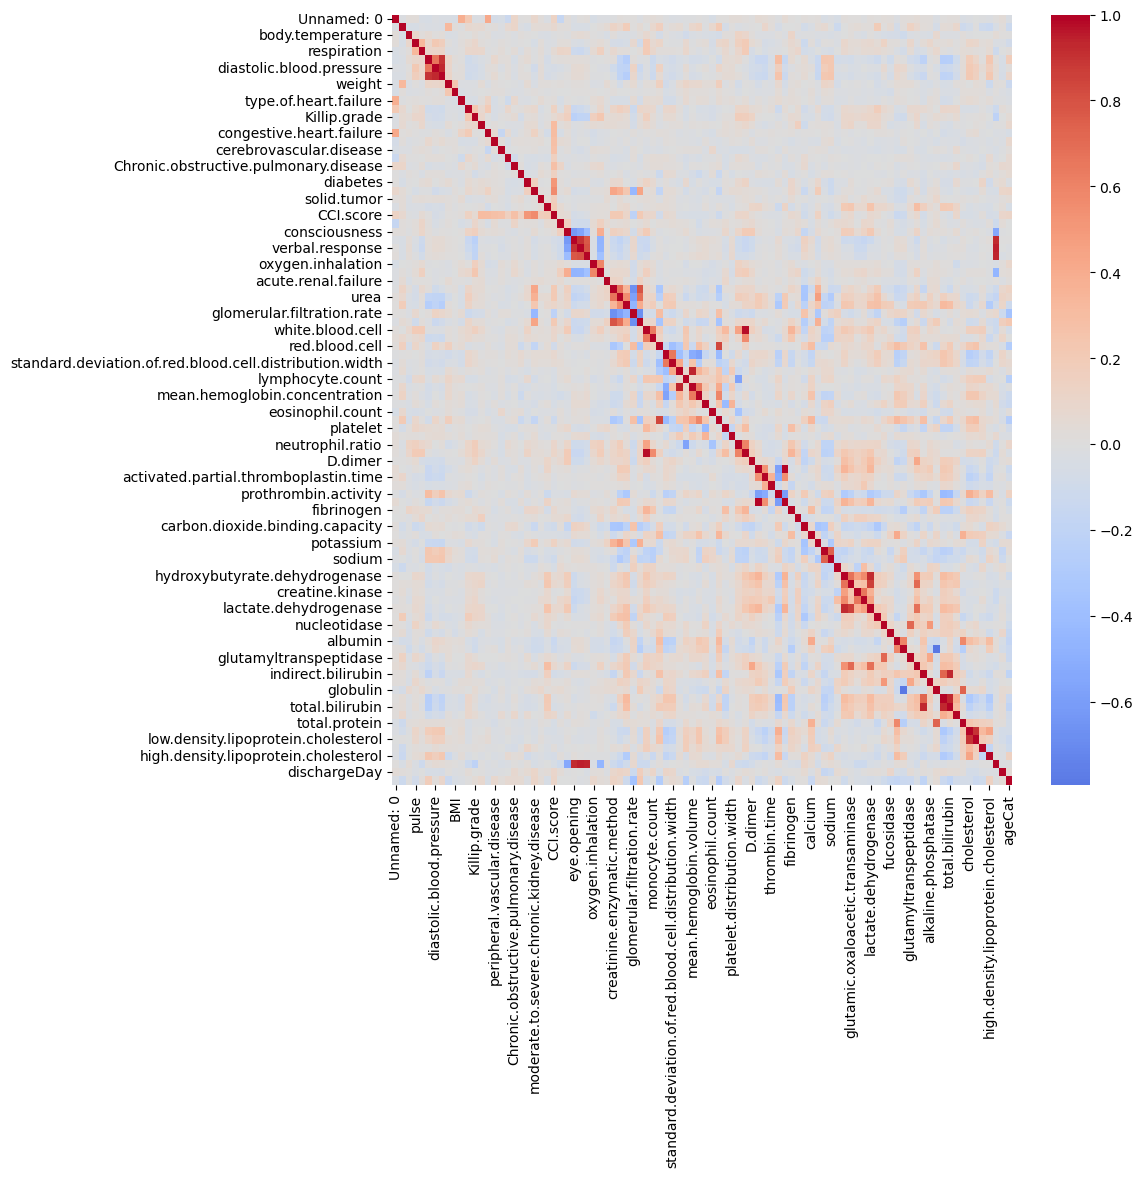

systolic.blood.pressure  - high multicorr: ['diastolic.blood.pressure', 'map']
diastolic.blood.pressure  - high multicorr: ['systolic.blood.pressure', 'map']
red.blood.cell  - high multicorr: ['hemoglobin']
hemoglobin  - high multicorr: ['red.blood.cell']
neutrophil.count  - high multicorr: ['white.blood.cell']
direct.bilirubin  - high multicorr: ['indirect.bilirubin', 'total.bilirubin']


In [144]:
# 3) multicollinearity:
# check for multicollinearity using pairwise correlations  
# convert feature columns to be corr() compatible

# create 1 y var:
# initial y options based on project goal of predicting survival outcome
y_initl = ["outcome.during.hospitalization", "death.within.28.days", "death.within.3.months", "death.within.6.months", "time.of.death..days.from.admission."]
y_cols = []
for col in y_initl:
    if col in df_sel.columns: # see which y options remain after missing & variance filter
        y_cols.append(col)
# print(y_cols) # [outome, 28d, 3mo, 6mo] (no time of death)
# outcome.during.hospitalization: ['Alive' 'Dead' 'DischargeAgainstOrder'] -> categorical
# death within xx: [0, 1] -> binary/boolean <- 0: false, 1: true

# make y categorical ordinal -> death @ hosp=0, 28d=1, 3mo=2, 6mo=3, alive6mo=4
outcome_series = pd.Series(name = 'outcome') # 'outcome' col
for row in range(len(df_sel)):
    if df_sel.loc[row, "outcome.during.hospitalization"] == 'Dead':
        outcome = 0
    elif df_sel.loc[row, "death.within.28.days"] == 1:
        outcome = 1
    elif df_sel.loc[row, "death.within.3.months"] == 1:
        outcome = 2
    elif df_sel.loc[row, "death.within.6.months"] == 1:
        outcome = 3
    else:
        outcome = 4
    outcome_series[row] = outcome
df_sel = df_sel.drop(columns=y_cols) # drop original y cols 
df_sel['outcome'] = outcome_series
df_num = df_num.drop(columns=y_cols) # update df_num too
df_num['outcome'] = outcome_series
# print(df_num.shape) # (2008, 94)  
# print(df_sel.shape) # (2008, 94)

# multicollinearity among x cols:
# remove high multicollinearity bc difficult to interpret var individual effects
# corr() = default pearson correlation
# multicolinearity cutoff: abs > 0.8
# use df_nump (no encoding) to compare x cols as a whole
xcorr_matrix = df_num.drop('outcome', axis=1).corr() # axis=1: drop column, axis=0: drop row
# print(xcorr_matrix)

# x corr heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(xcorr_matrix, cmap='coolwarm', center=0)
plt.show()

# upper triangle of correlation matrix
# np.tri() = extract lower/upper triangle of matrix/array
# np.ones(shape) = array of 1s w/ input shape
# k=1: diagonal above main diagonal, k=0: main diagonal
xupper_corr = xcorr_matrix.where(np.triu(np.ones(xcorr_matrix.shape), k=1).astype(np.bool)) 

# high_corr of values that exceed threshold
multi_thresh = 0.8
xhigh_corrs = []
for xcol in xupper_corr.columns:
    xhigh = xupper_corr[xcol][abs(xupper_corr[xcol]) > multi_thresh].index.tolist() # list of col names
    if len(xhigh) > 0:
        xhigh_corrs.append((xcol, xhigh)) # append tuple to list
        # print(xcol, ": ", xhigh) # 11 pairs

# see which of pairs best correlated to outcome; drop rest
corrs_drop = set() # set = set(), dict = {}
for pair in xhigh_corrs:
    col1 = pair[0]
    col_max = col1 # initialize, defaults 1st col
    corr_max = df_num[col1].corr(df_num['outcome']) # initialize, defaults 1st col

    for col in pair[1]:
        corr = df_num[col].corr(df_num['outcome'])
        if abs(corr) > abs(corr_max):
            corr_max = corr
            col_max = col

    frm_pair = pair[1] + [pair[0]] # all cols in pair
    frm_pair.remove(col_max) # remove col to keep
    # print(frm_pair)
    corrs_drop.update(frm_pair)
# print(corrs_drop)

# cross-check w/ literature ftrs before confirming drop:
for ftr in lit_ftrs:
    for pair in xhigh_corrs:
        frm_pair = pair[1] + [pair[0]]
        if ftr in frm_pair:
            frm_pair.remove(ftr) 
            print(ftr, " - high multicorr:", frm_pair)
# systolic.blood.pressure  - high multicorr: ['diastolic.blood.pressure', 'map']
# diastolic.blood.pressure  - high multicorr: ['systolic.blood.pressure', 'map']
# red.blood.cell  - high multicorr: ['hemoglobin']
# hemoglobin  - high multicorr: ['red.blood.cell']
# neutrophil.count  - high multicorr: ['white.blood.cell']
# direct.bilirubin  - high multicorr: ['indirect.bilirubin', 'total.bilirubin']
# makes sense clinically - keep all
# ie. SBP & DBP: directly calculates MAP so makes sense highly correlated
for ftr in lit_ftrs:
    if ftr in corrs_drop:
        corrs_drop.remove(ftr)
df_sel = df_sel.drop(columns=corrs_drop)
# print(df_sel.shape) # (2008, 83)
# don't need to update df_num bc no longer need

In [145]:
# 4) pairwise correlations:
# corr() for 'outcome' v. x cols
# pearson corr: <0.3=weak, 0.3-0.7=moderate, >0.7=strong
df_corr = df_sel.copy() # df w/ trnasformed cols just for correlation

# split categorical into ordinal & nominal:
df_cats = df_sel.select_dtypes(include=['object', 'category'])  

# print(cats_df.columns)
# ['gender', 'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade',  'type.II.respiratory.failure', 'consciousness', 'oxygen.inhalation', 'ageCat']
for col in df_cats.columns:
    cats_tot = df_cats[col].unique()
    print(col, ": ", cats_tot) # see categories
# gender :  ['Male' 'Female']
# type.of.heart.failure :  ['Both' 'Right' 'Left']
# NYHA.cardiac.function.classification :  ['III' 'II' 'IV']
# Killip.grade :  ['III' 'I' 'II' 'IV']
# type.II.respiratory.failure :  ['NonTypeII' 'TypeII']
# consciousness :  ['Clear' 'ResponsiveToPain' 'ResponsiveToSound' 'Nonresponsive'] # AVPU scale = ordinal
# oxygen.inhalation :  ['OxygenTherapy' 'AmbientAir']
# ageCat :  ['(69,79]' '(59,69]' '(79,89]' '(49,59]' '(89,110]' '(29,39]' '(39,49]' '(21,29]']
ord_cols = ['NYHA.cardiac.function.classification', 'Killip.grade', 'consciousness', 'ageCat']
ord_cats = {'NYHA.cardiac.function.classification': ['II', 'III', 'IV'],
            'Killip.grade': ['I', 'II', 'III', 'IV'],
            'consciousness': ['Nonresponsive', 'ResponsiveToPain', 'ResponsiveToSound', 'Clear'],
            'ageCat': ['(21,29]', '(29,39]', '(39,49]', '(49,59]', '(59,69]', '(69,79]', '(79,89]', '(89,110]']}
# ^ dictionary = {}
nom_cols = ['type.of.heart.failure']
bin_cols = ['gender', 'type.II.respiratory.failure', 'oxygen.inhalation']

# categorical ordinal -> pd.Categorical & .cat.codes:
# redefine with pd.Categorical with categories=set_order to add set category order
# df[col].cat.codes = convert to numerical 
for col in ord_cols:
    order = ord_cats[col]
    # print(order)
    df_sel[col] = pd.Categorical(df_sel[col], categories=order, ordered=True)
    df_corr[col] = df_sel[col].cat.codes # replace
# print(df_corr.head(3))

# categorical nominal -> ohe:
df_ohe = pd.get_dummies(df_corr[nom_cols]) # don't drop_first=True
df_corr = df_corr.drop(columns=nom_cols)
df_corr = pd.concat([df_corr, df_ohe], axis=1) # axis=1: add as column, axis=0: add as row
# print(df_corr.head(3))

# binary nominal -> .cat.codes (0/1):
for col in bin_cols:
    df_sel[col] = pd.Categorical(df_sel[col])
    df_corr[col] = df_sel[col].cat.codes # replace
    # check code assignments:
    # mapping = dict(enumerate(df_sel[col].cat.categories))
    # print(mapping)
# print(df_corr.head(3))
# {0: 'Female', 1: 'Male'}
# {0: 'NonTypeII', 1: 'TypeII'}
# {0: 'AmbientAir', 1: 'OxygenTherapy'}

# outcome corrs:
corr_matrix = df_corr.corr()  
outcome_corrs = corr_matrix['outcome'] # correlations w 'outcome' col
outcome_corrs = outcome_corrs.sort_values(ascending=False, key=abs) # key=abs: sort by magnitude

# start list of all cols to keep:
keep = []  
# intialize w/ remianing lit ftrs
for ftr in lit_ftrs:
    if ftr in df_sel.columns:
        keep.append(ftr)
# print(keep) 
# print(len(keep)) # 26

# corr >=0.3 moderate
corr_thresh = 0.3 
high_corrs = outcome_corrs[abs(outcome_corrs) >= corr_thresh] # series w/ x names as index - keep
# print(high_corrs) # only 2 x cols - consciousness & eye.opening
# data limitation: not enough info on eye-opening variable collection & meaning -> only add consciousness
keep.append('consciousness') # add as index names list - includes 'outcome'
# print(keep) 
# print(len(keep)) # 28
# print(len(keep) == len(set(keep))) # True  

gender :  ['Male' 'Female']
type.of.heart.failure :  ['Both' 'Right' 'Left']
NYHA.cardiac.function.classification :  ['III' 'II' 'IV']
Killip.grade :  ['III' 'I' 'II' 'IV']
type.II.respiratory.failure :  ['NonTypeII' 'TypeII']
consciousness :  ['Clear' 'ResponsiveToPain' 'ResponsiveToSound' 'Nonresponsive']
oxygen.inhalation :  ['OxygenTherapy' 'AmbientAir']
ageCat :  ['(69,79]' '(59,69]' '(79,89]' '(49,59]' '(89,110]' '(29,39]' '(39,49]'
 '(21,29]']


In [146]:
# 5) univariate screening:
# anova to compare each feature relationship w/ outcome
# use statsmodels to fit factorial anova -> * = achieve main effects & interaction
# clean df by dropping 1st "unnamed" col 
df_sel = df_sel.drop(columns=['Unnamed: 0']) 

# loop through each feature for anova 1by1:
# syntax: need to rename columns without "." (nor spaces) -> replace with "_"
df_anova = df_sel.copy() # not based on keep to add more relevant features
df_anova = df_anova.rename(columns=lambda x: x.replace(".", "_")) # lambda = one-line anonymous fxn

# anova table = anova_lm(model, type=#)
# type i: balanced designs w simple, hierarchical model, type ii: unbalanced designs w no interactions; type iii: unbalanced designs w interactions 
# if alpha=0.05, significant if p < 0.05 -> p = anova_table['PR(>F)'][0]
a = 0.01 # 0.05 yield 49 results -> make more stringent
all_p = {} # dict
sig_p = {} 
for col in df_anova.columns:
    if (df_anova[col].dtype != 'object' and df_anova[col].dtype != 'category'): # quantitative
            formula = f"outcome ~ {col}"
    else: # categorical
        formula = f"outcome ~ C({col})"
    model = smf.ols(formula=formula, data=df_anova).fit() # need to keep "_" replaced names for model / entire anova process
    anova_table = sm.stats.anova_lm(model, typ=2)
    p = float(anova_table['PR(>F)'].iloc[0]) # can't combine raw bracket indexing of label & index -> use .iloc[] for # index
    col = col.replace("_", ".") # revert to og
    all_p[col] = p
    if p < a:
        sig_p[col] = p # append as dict key-val pair
# print(sig_p) 
# print(len(sig_p)) # 37

# check discrepancies btwn keep & sig_cols -> manually edit based on clinical relevance & p-value:
# keep ftrs not in sig_p:
for ftr in keep:
    if not ftr in sig_p:
        p = all_p[ftr]
        print(ftr, ": p=", p)
# remove: dementia, coefficient.of.variation.of.red.blood.cell.distribution.width 
keep.remove('dementia') 
keep.remove('coefficient.of.variation.of.red.blood.cell.distribution.width')

# sig_p ftrs not in keep:
for key in sig_p:
    if not key in keep:
        corr = outcome_corrs[key]
        print(key, ": corr=", corr)
# add: congestive.heart.failure, mean.platelet.volume 
keep.append('congestive.heart.failure')
keep.append('mean.platelet.volume')
# print(keep)
# print(len(keep)) # 28

# ftrs in both:
for ftr in keep:
    if not ftr in lit_ftrs:
        p = all_p[ftr]
        corr = outcome_corrs[ftr]
        print(ftr, ": p =", p, ", corr=", corr)
# remove: neutrophil.count, myocardial.infarction
keep.remove('neutrophil.count')
keep.remove('myocardial.infarction')
# print(keep)
# print(len(keep)) # 26

# final df:
keep.append('outcome')  
df_sel = df_sel[keep]
# print(df_sel.head(2)) 
# print(df_sel.shape) # (2008, 27)

ageCat : p= 0.990990730235781
BMI : p= 0.6265019244401878
myocardial.infarction : p= 0.9428156546775373
peripheral.vascular.disease : p= 0.912649392354216
Chronic.obstructive.pulmonary.disease : p= 0.4333885990816433
dementia : p= 0.2586022101249821
diabetes : p= 0.9481592955195759
systolic.blood.pressure : p= 0.042678633250108476
diastolic.blood.pressure : p= 0.01110531142548593
gender : p= 0.03206975123442985
red.blood.cell : p= 0.04533581551085275
hemoglobin : p= 0.042668903259718796
direct.bilirubin : p= 0.01028394681333168
coefficient.of.variation.of.red.blood.cell.distribution.width : p= 0.3551791447968684
respiration : corr= -0.06294505105314131
congestive.heart.failure : corr= 0.05862348659428282
liver.disease : corr= -0.08339591614291202
type.II.respiratory.failure : corr= -0.10316811893611733
eye.opening : corr= 0.48193773996268213
fio2 : corr= -0.2401048334432765
urea : corr= -0.2020323426690508
glomerular.filtration.rate : corr= 0.099886585028625
cystatin : corr= -0.1614501

In [147]:
# FINAL DF

# rename for simplicity:
df = df_sel.copy()
df.head()

,ageCat,BMI,peripheral.vascular.disease,Chronic.obstructive.pulmonary.disease,moderate.to.severe.chronic.kidney.disease,NYHA.cardiac.function.classification,acute.renal.failure,diabetes,Killip.grade,systolic.blood.pressure,diastolic.blood.pressure,gender,red.blood.cell,hemoglobin,neutrophil.ratio,glutamic.pyruvic.transaminase,direct.bilirubin,creatinine.enzymatic.method,uric.acid,potassium,chloride,sodium,brain.natriuretic.peptide,consciousness,congestive.heart.failure,mean.platelet.volume,outcome
0,"(69,79]",18.590125,0,1,0.0,III,0,1,III,102,64,Male,4.09,131.0,0.746,65.0,6.9,108.3,685.0,5.59,101.9,134.6,1500.17,Clear,0,14.0,4
1,"(69,79]",19.195303,0,0,0.0,III,0,0,I,150,70,Female,3.93,114.0,0.702,19.0,5.2,62.0,170.0,3.62,105.6,144.0,361.70,Clear,0,11.3,4
2,"(59,69]",24.221453,0,0,0.0,II,0,0,II,102,67,Male,4.43,144.0,0.887,10.0,4.4,185.1,567.0,4.15,107.0,142.2,293.95,Clear,0,12.0,4
3,"(69,79]",22.491349,0,1,1.0,III,0,0,II,110,74,Male,2.71,94.0,0.559,9.0,25.4,104.8,635.0,3.76,101.6,136.3,1071.40,Clear,0,12.4,4
4,"(69,79]",31.633715,0,0,0.0,III,0,0,II,134,62,Female,4.20,120.0,0.697,19.0,4.9,83.9,432.0,3.94,104.3,136.6,372.87,Clear,0,12.6,4


In [148]:
# prepare the feature matrix X
X = df.loc[:, df.columns != 'outcome']
# print(X.head())
# print(X.shape) # (2008, 27)

# prepare the target variable y (recidivism)
# y = just target variale (recidivism)
y = df['outcome']
# print(y.head())
# print(y.shape) # (2008,)

In [149]:
# EDA
# visualize individual variables:

# target variable:
# hosp=0, 28d=1, 3mo=2, 6mo=3, alive6mo=4
# plt.figure(figsize=(10, 10))
# y.value_counts().plot.bar()
# plt.xticks([0, 1, 2, 3, 4], # tick index starts at 0 (not 1)
#            ['0: death at hospital', '1: death within 28days', '2: death within 3mo', '3: death within 6mo', '4: alive at 6mo'],
#            rotation=0) # x-axis labels rotated to be horizontal (not vertical)
# plt.xlabel('recidivation status within 2 years of scoring')
# plt.ylabel('survival outcome')
# plt.title('survival outcome of heart failure patients')
# plt.tight_layout()
# plt.show()


In [150]:
# EDA
# visualize outcome vs. features:

# sort categorical & continuous features:
cat_cols = ['NYHA.cardiac.function.classification', 'Killip.grade', 'consciousness', 'ageCat', 'gender',
            'peripheral.vascular.disease', 'Chronic.obstructive.pulmonary.disease', 'moderate.to.severe.chronic.kidney.disease', 
            'acute.renal.failure', 'diabetes', 'congestive.heart.failure', 'peripheral.vascular.disease']
# print(cat_cols)
# print(len(cat_cols)) # 12
not_cont = cat_cols + ['outcome']
cont_cols = list(set(df.columns) - set(not_cont))
# print(len(cont_cols)) # 15
# print(len(df.columns)) # 27
# print(cont_cols)
# ['diastolic.blood.pressure', 'brain.natriuretic.peptide', 'chloride', 'red.blood.cell', 'potassium', 'creatinine.enzymatic.method', 'hemoglobin', 'direct.bilirubin', 'sodium', 'BMI', 'mean.platelet.volume', 'uric.acid', 'glutamic.pyruvic.transaminase', 'neutrophil.ratio', 'systolic.blood.pressure']


In [151]:
df.head()

,ageCat,BMI,peripheral.vascular.disease,Chronic.obstructive.pulmonary.disease,moderate.to.severe.chronic.kidney.disease,NYHA.cardiac.function.classification,acute.renal.failure,diabetes,Killip.grade,systolic.blood.pressure,diastolic.blood.pressure,gender,red.blood.cell,hemoglobin,neutrophil.ratio,glutamic.pyruvic.transaminase,direct.bilirubin,creatinine.enzymatic.method,uric.acid,potassium,chloride,sodium,brain.natriuretic.peptide,consciousness,congestive.heart.failure,mean.platelet.volume,outcome
0,"(69,79]",18.590125,0,1,0.0,III,0,1,III,102,64,Male,4.09,131.0,0.746,65.0,6.9,108.3,685.0,5.59,101.9,134.6,1500.17,Clear,0,14.0,4
1,"(69,79]",19.195303,0,0,0.0,III,0,0,I,150,70,Female,3.93,114.0,0.702,19.0,5.2,62.0,170.0,3.62,105.6,144.0,361.70,Clear,0,11.3,4
2,"(59,69]",24.221453,0,0,0.0,II,0,0,II,102,67,Male,4.43,144.0,0.887,10.0,4.4,185.1,567.0,4.15,107.0,142.2,293.95,Clear,0,12.0,4
3,"(69,79]",22.491349,0,1,1.0,III,0,0,II,110,74,Male,2.71,94.0,0.559,9.0,25.4,104.8,635.0,3.76,101.6,136.3,1071.40,Clear,0,12.4,4
4,"(69,79]",31.633715,0,0,0.0,III,0,0,II,134,62,Female,4.20,120.0,0.697,19.0,4.9,83.9,432.0,3.94,104.3,136.6,372.87,Clear,0,12.6,4


/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1846379092.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby([col, 'outcome']).size().unstack()


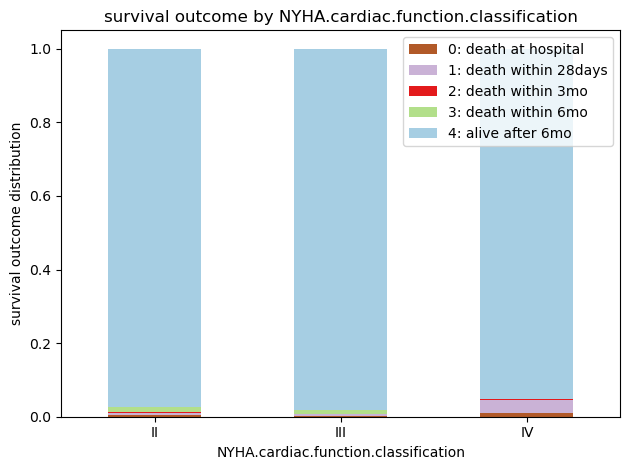

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1846379092.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby([col, 'outcome']).size().unstack()


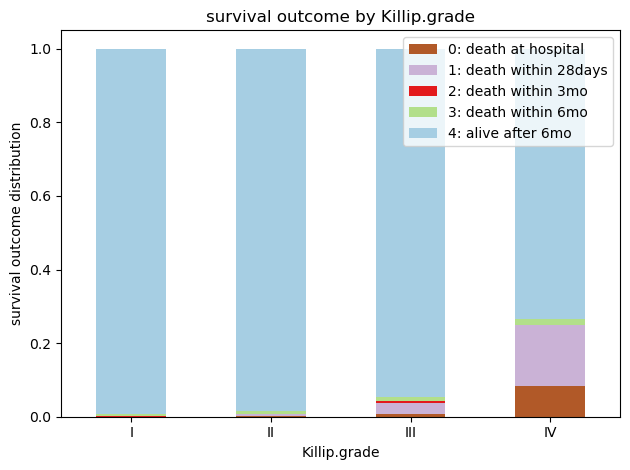

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1846379092.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby([col, 'outcome']).size().unstack()


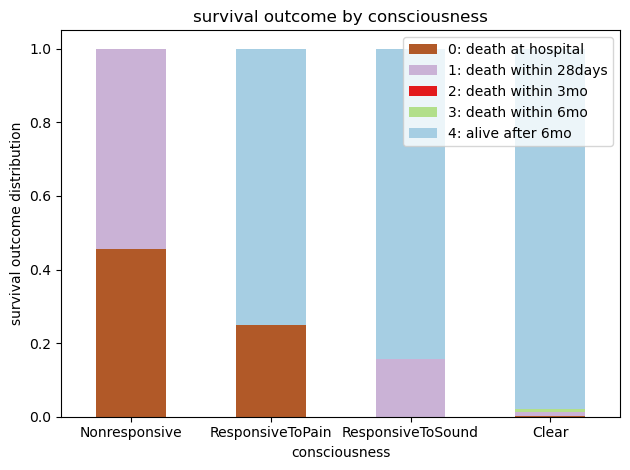

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1846379092.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby([col, 'outcome']).size().unstack()


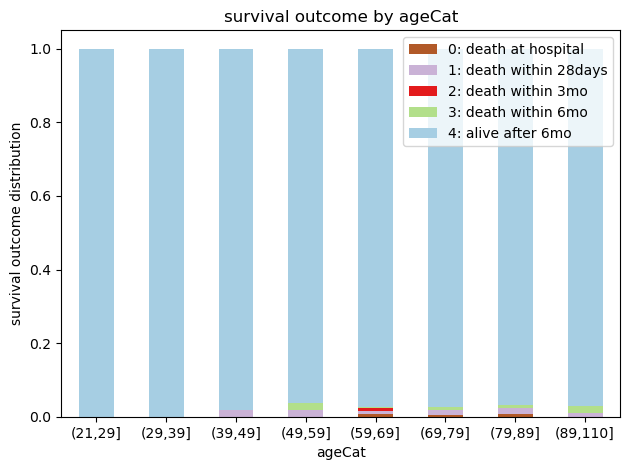

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1846379092.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby([col, 'outcome']).size().unstack()


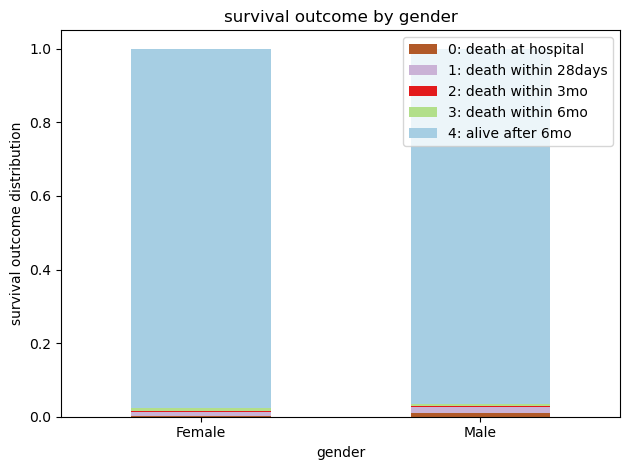

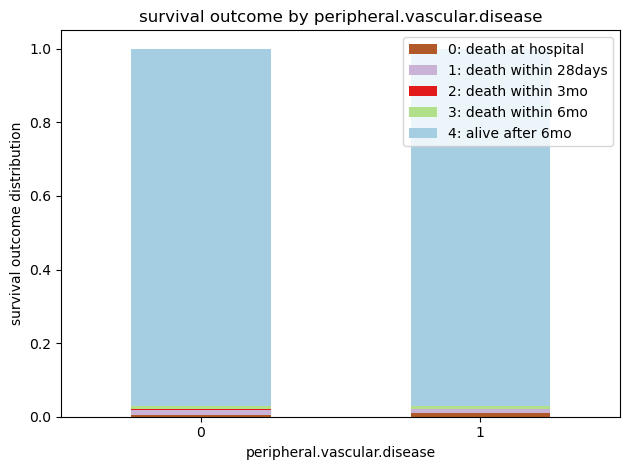

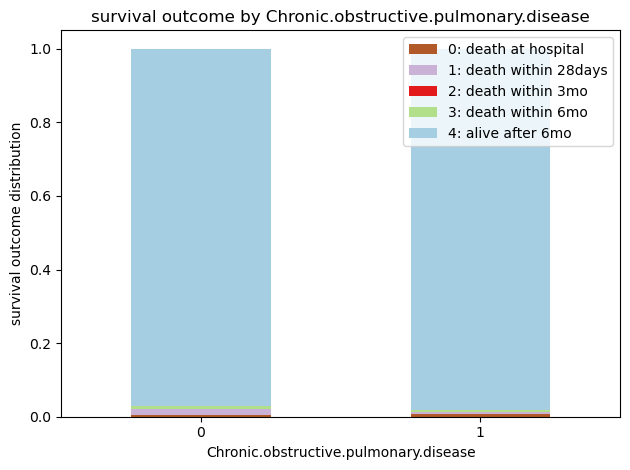

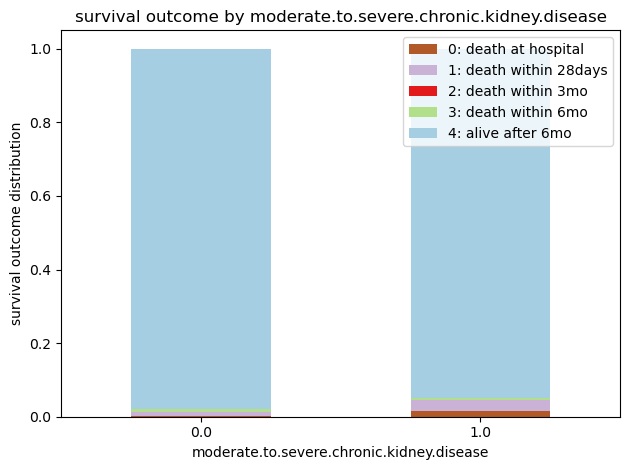

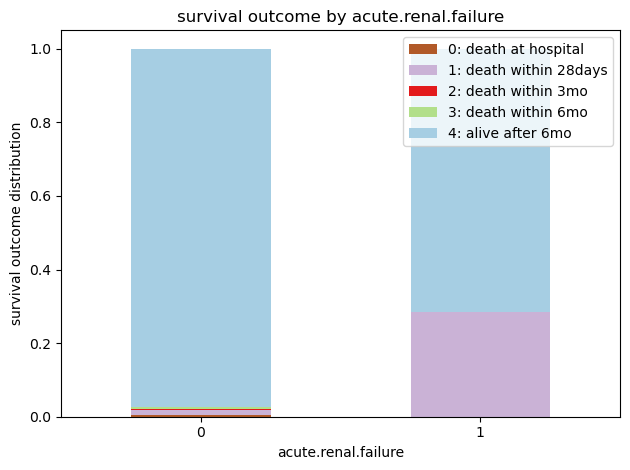

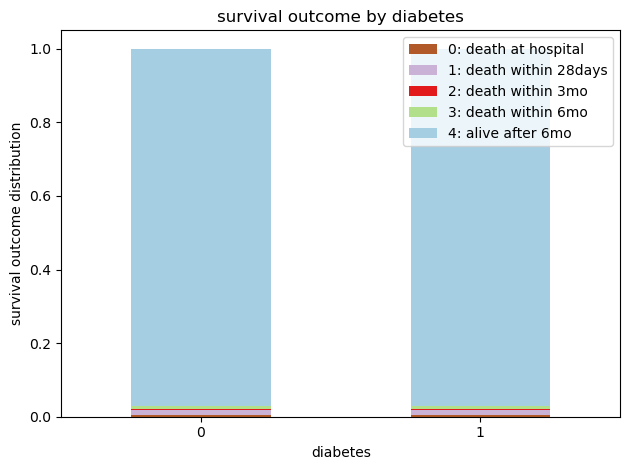

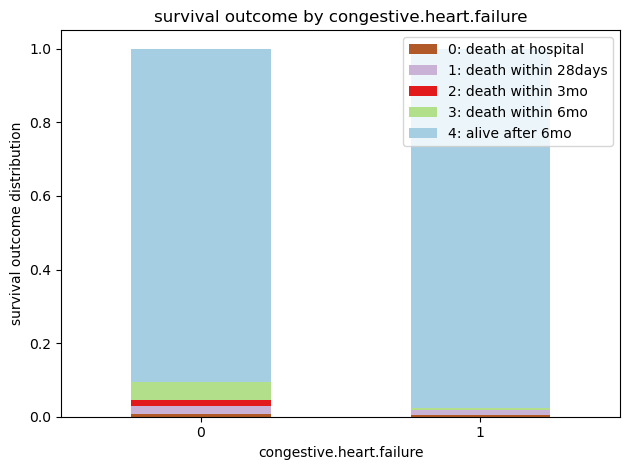

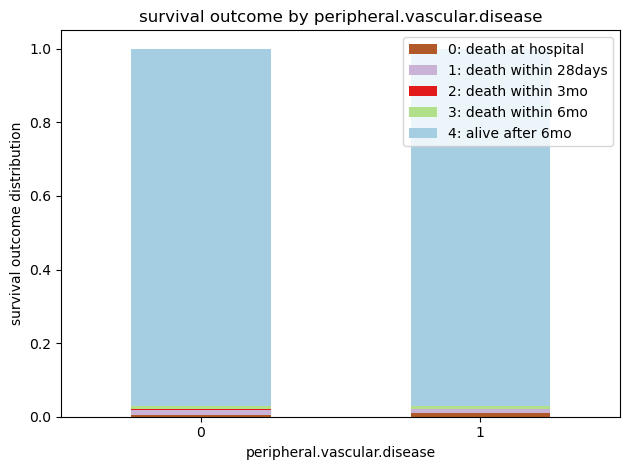

In [152]:
# EDA
# categorical x v. outcome:

# categorical v. categorical = stacked bar plot
for col in cat_cols:
    count_matrix = df.groupby([col, 'outcome']).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

    count_matrix_norm.plot(kind='bar', stacked=True, cmap='Paired_r') # ,figsize=(5,3)
    plt.title(f'survival outcome by {col}')
    plt.xticks(rotation=0)
    plt.xlabel(col)
    plt.ylabel('survival outcome distribution')
    # plt.legend(loc=0)
    plt.legend(labels=['0: death at hospital', '1: death within 28days', '2: death within 3mo', '3: death within 6mo', '4: alive after 6mo'],
                loc='upper right')
    plt.tight_layout()
    plt.show()

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1741801242.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby(['outcome', col]).size().unstack()


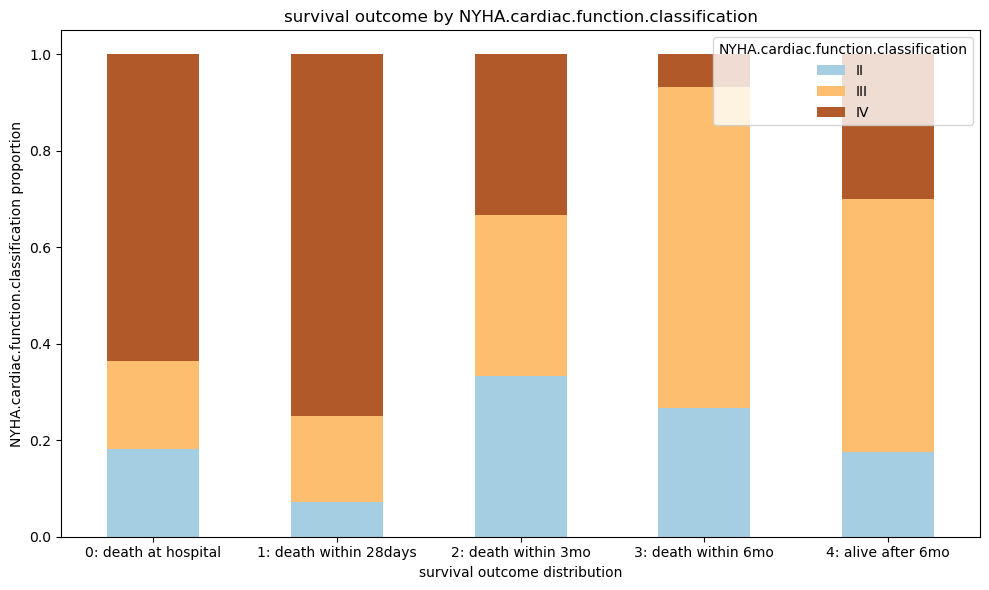

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1741801242.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby(['outcome', col]).size().unstack()


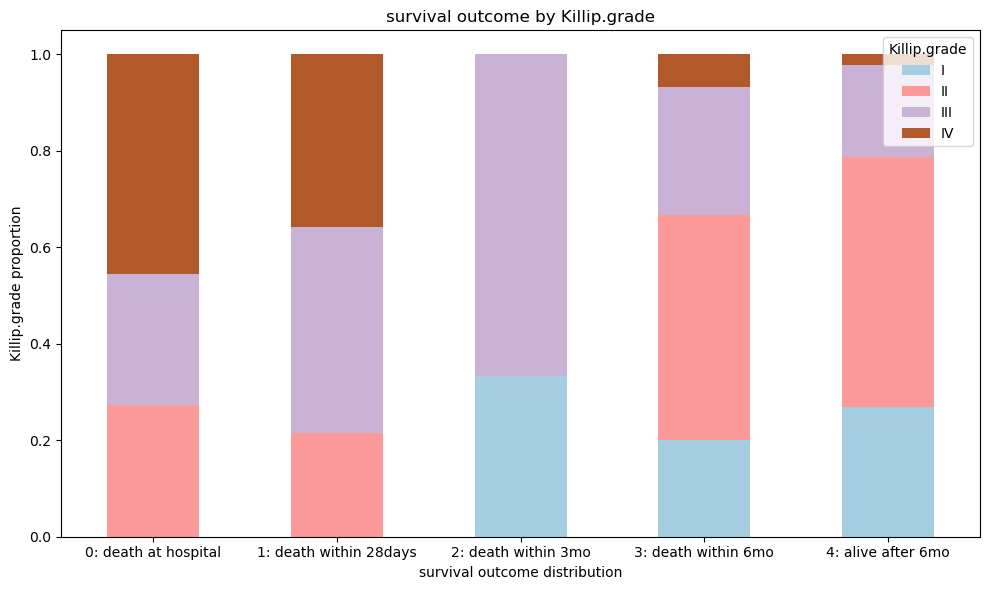

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1741801242.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby(['outcome', col]).size().unstack()


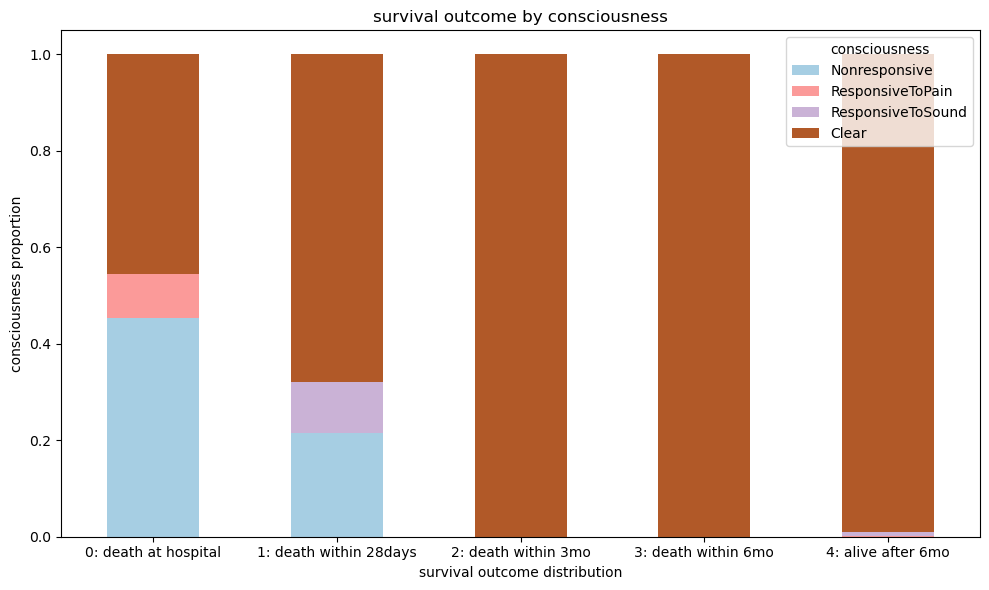

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1741801242.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby(['outcome', col]).size().unstack()


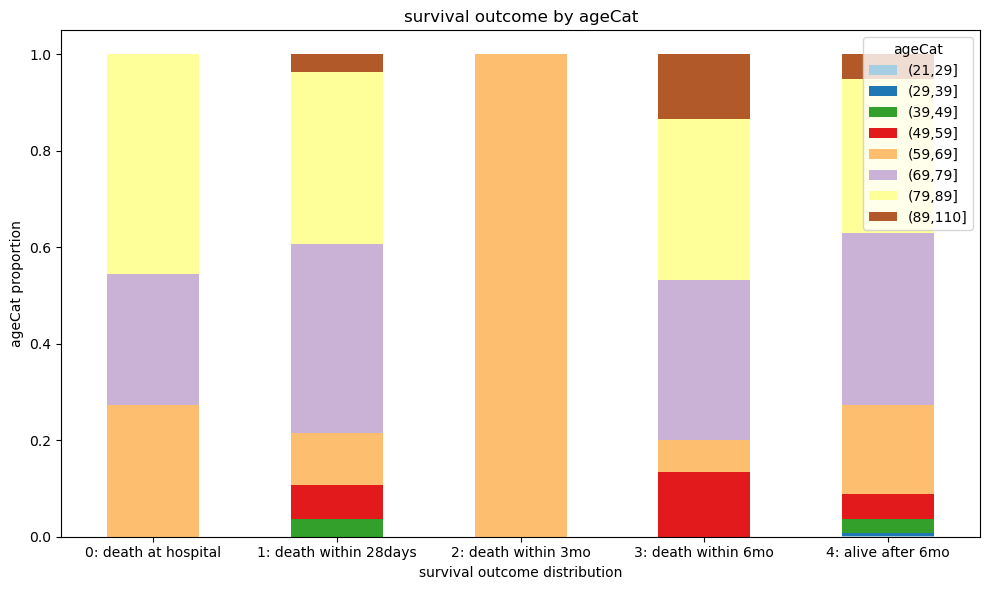

/var/folders/y7/cgyhr68x2mnfgdsyplzhtlt40000gn/T/ipykernel_82938/1741801242.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_matrix = df.groupby(['outcome', col]).size().unstack()


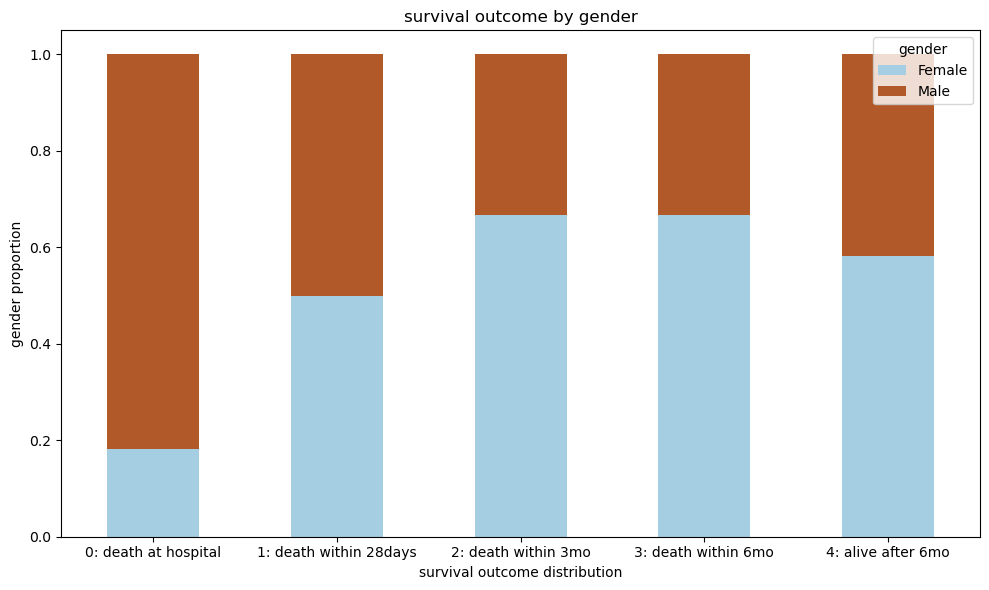

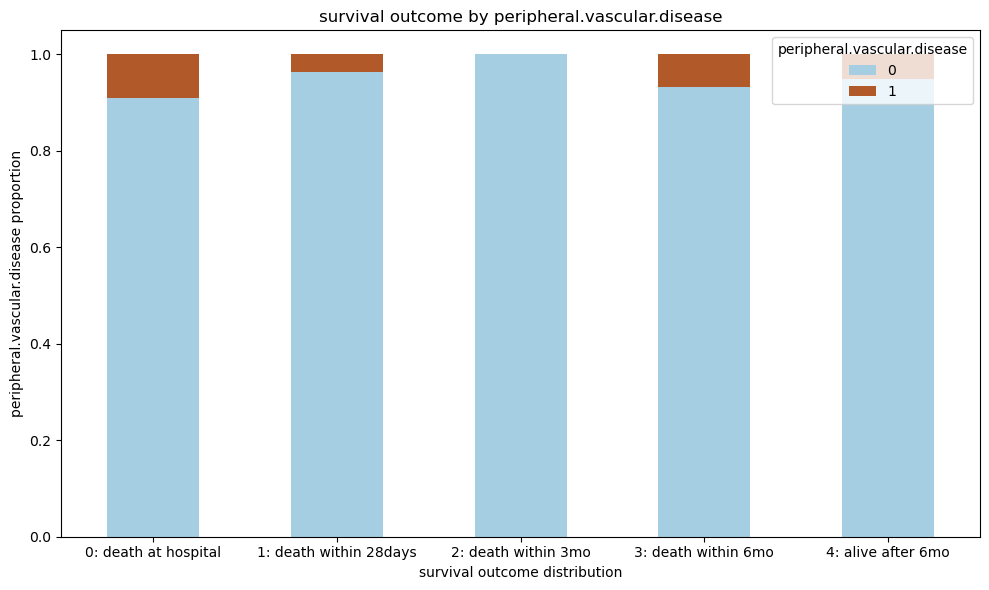

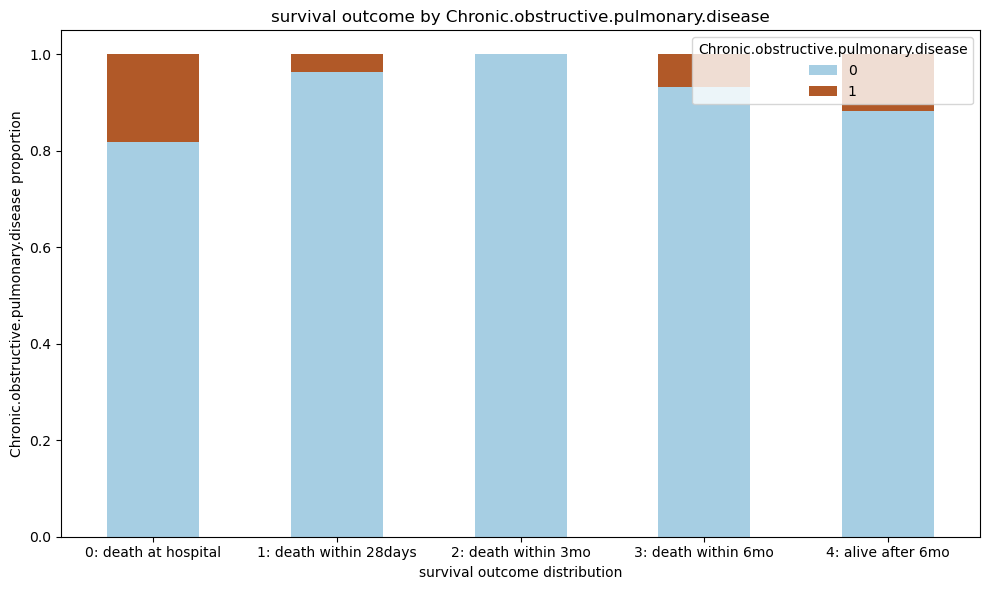

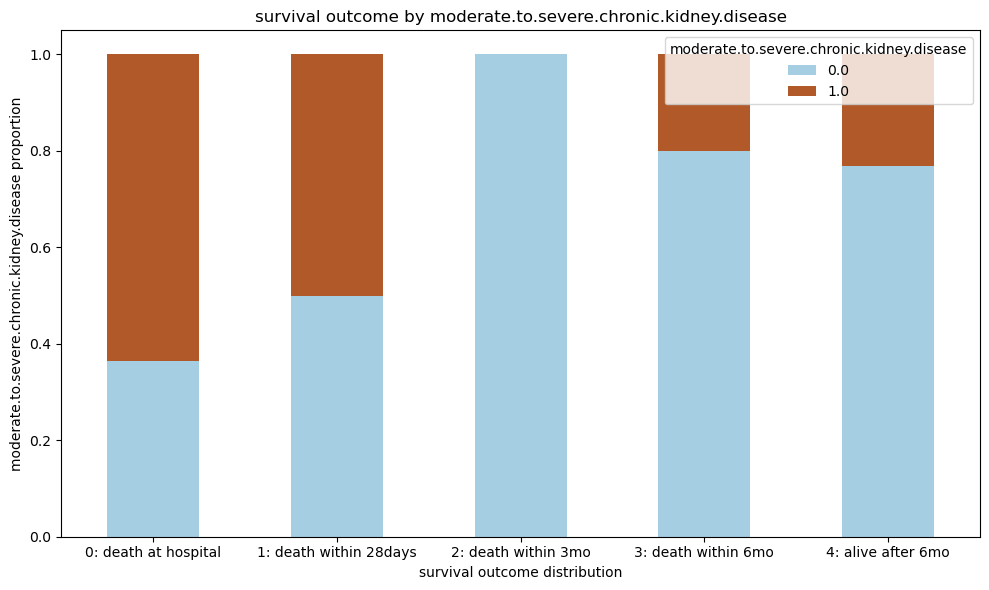

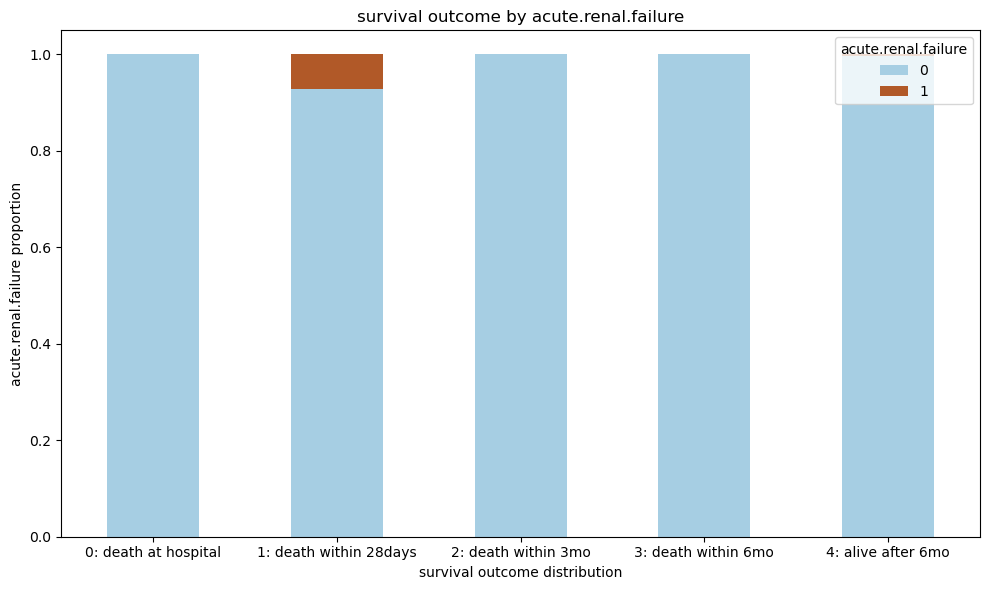

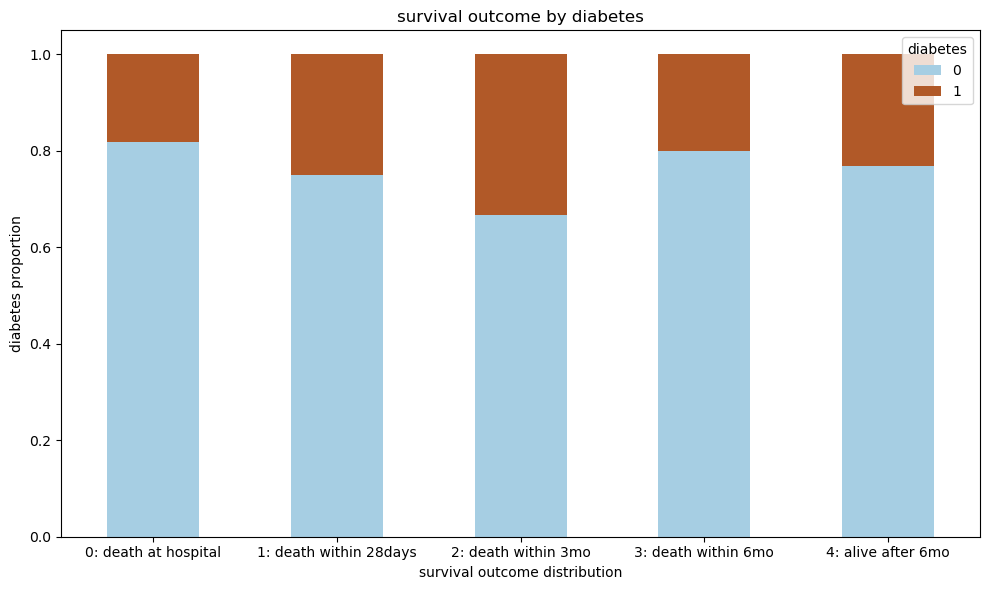

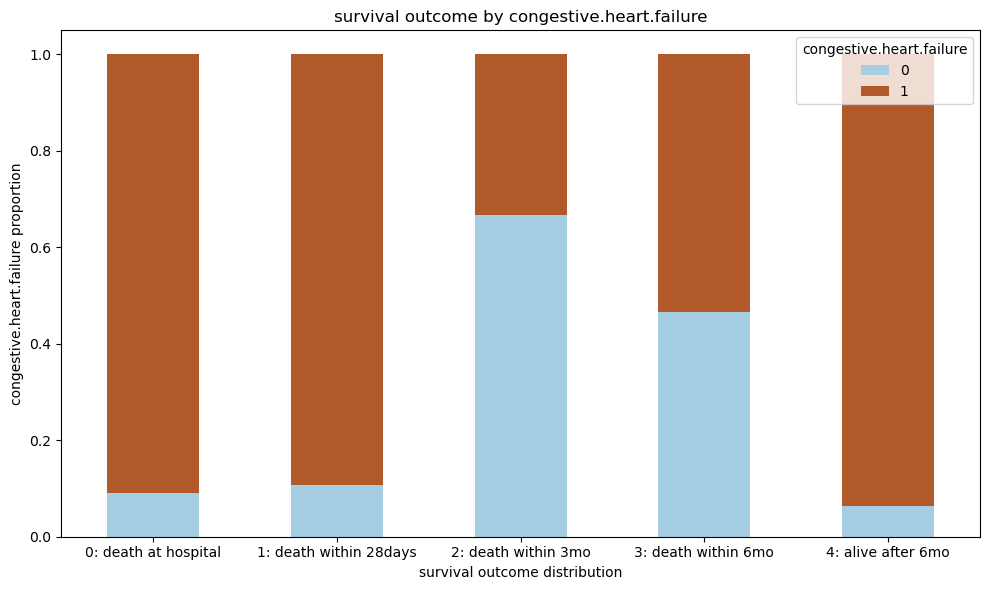

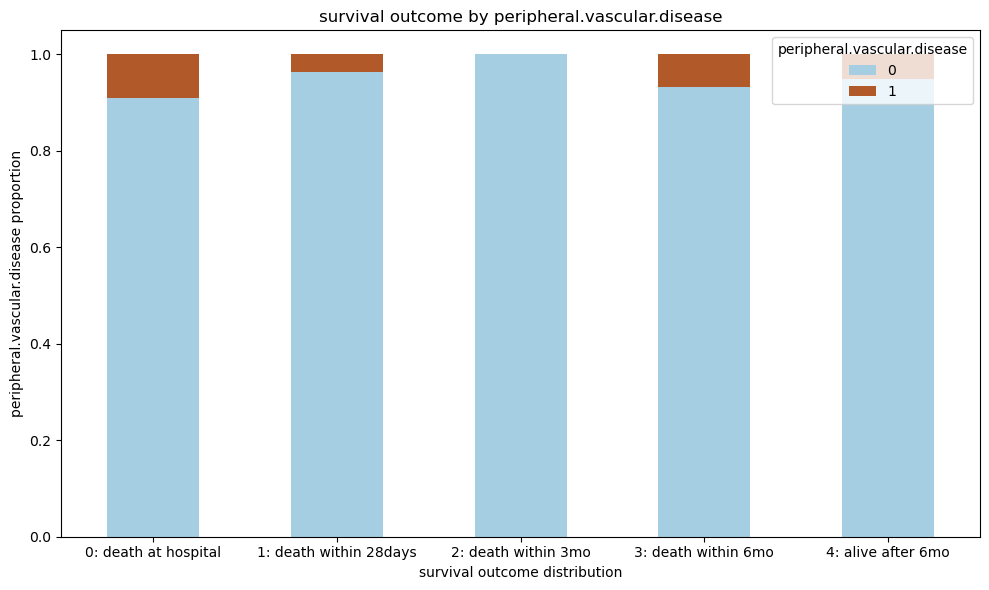

In [153]:
# EDA
# categorical x v. outcome:
# switch x & y?

# categorical v. categorical = stacked bar plot
for col in cat_cols:
    count_matrix = df.groupby(['outcome', col]).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

    count_matrix_norm.plot(kind='bar', stacked=True, cmap='Paired', figsize=(10,6))
    plt.title(f'survival outcome by {col}')
    plt.xticks([0, 1, 2, 3, 4],
               ['0: death at hospital', '1: death within 28days', '2: death within 3mo', '3: death within 6mo', '4: alive after 6mo'],
               rotation=0)
    plt.xlabel('survival outcome distribution')
    plt.ylabel(f'{col} proportion')
    # plt.legend(loc=0)
    plt.legend(title=col, loc='upper right')
    plt.tight_layout()
    plt.show()

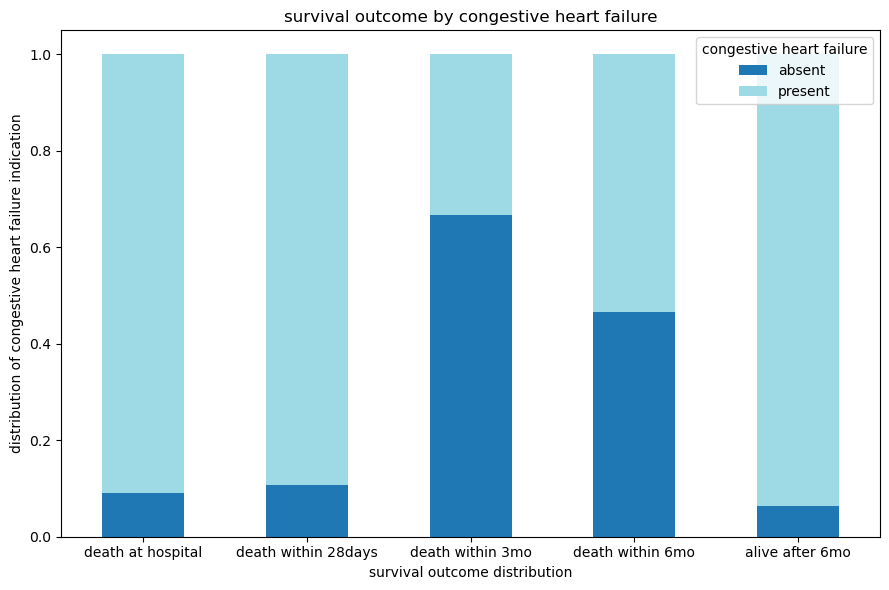

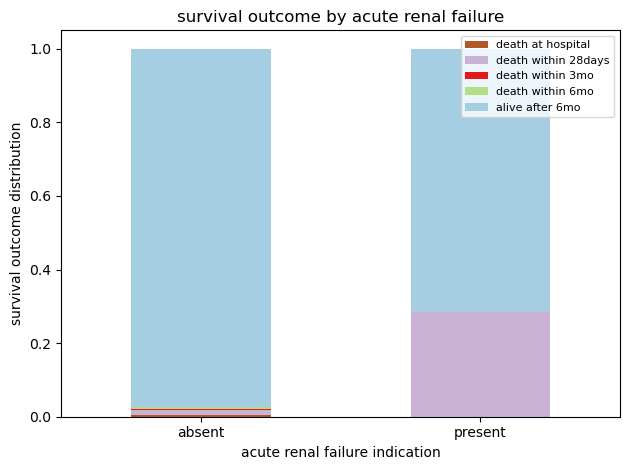

acute renal failure = 0
  outcome = 0: 0.55%
  outcome = 1: 1.30%
  outcome = 2: 0.15%
  outcome = 3: 0.75%
  outcome = 4: 97.25%
acute renal failure = 1
  outcome = 0: nan%
  outcome = 1: 28.57%
  outcome = 2: nan%
  outcome = 3: nan%
  outcome = 4: 71.43%


In [166]:
# EDA
# categorical x v. outcome:
# for presentation:

# chf:
count_matrix = df.groupby(['outcome', 'congestive.heart.failure']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, cmap='tab20', figsize=(9,6))
plt.title(f'survival outcome by congestive heart failure')
plt.xticks([0, 1, 2, 3, 4],
            ['death at hospital', 'death within 28days', 'death within 3mo', 'death within 6mo', 'alive after 6mo'],
            rotation=0)
plt.xlabel('survival outcome distribution')
plt.ylabel(f'distribution of congestive heart failure indication')
plt.legend(title='congestive heart failure', loc='upper right', 
           labels=['absent', 'present'])
plt.tight_layout()
plt.show()

# acute renal failure:
count_matrix = df.groupby(['acute.renal.failure', 'outcome']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, cmap='Paired_r')
plt.title(f'survival outcome by acute renal failure')
plt.xticks([0, 1], ['absent', 'present'], rotation=0)
plt.xlabel('acute renal failure indication')
plt.ylabel('survival outcome distribution')
plt.legend(labels=['death at hospital', 'death within 28days', 'death within 3mo', 'death within 6mo', 'alive after 6mo'],
            loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()
# proportions:
for renal_incidence in [0, 1]:
    total = count_matrix.loc[renal_incidence].sum()
    print(f"acute renal failure = {renal_incidence}")
    for outcome in range(5):
        count = count_matrix.loc[renal_incidence, outcome]
        prop = count / total * 100
        print(f"  outcome = {outcome}: {prop:.2f}%")

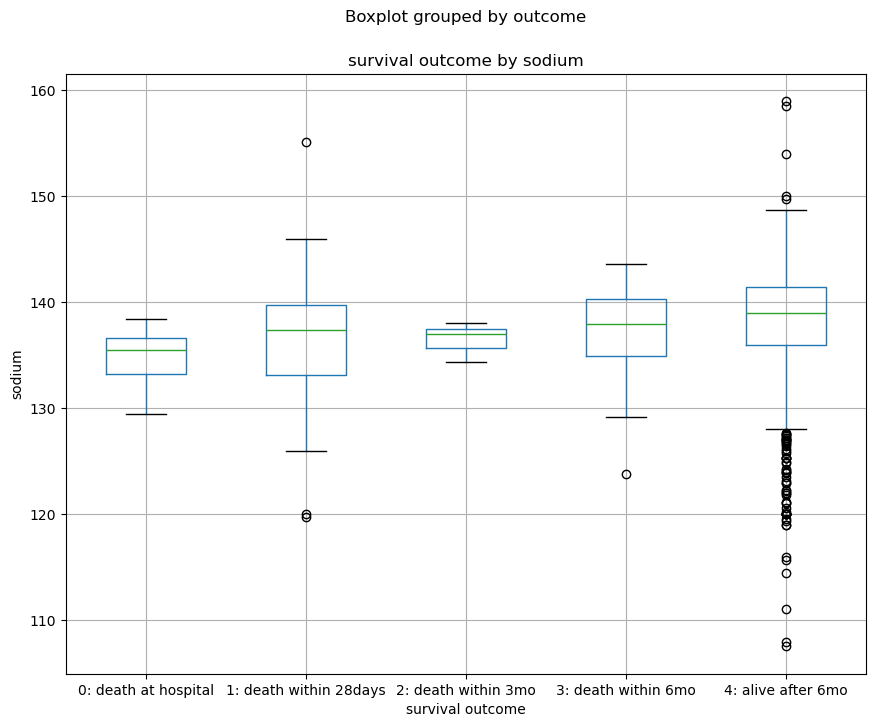

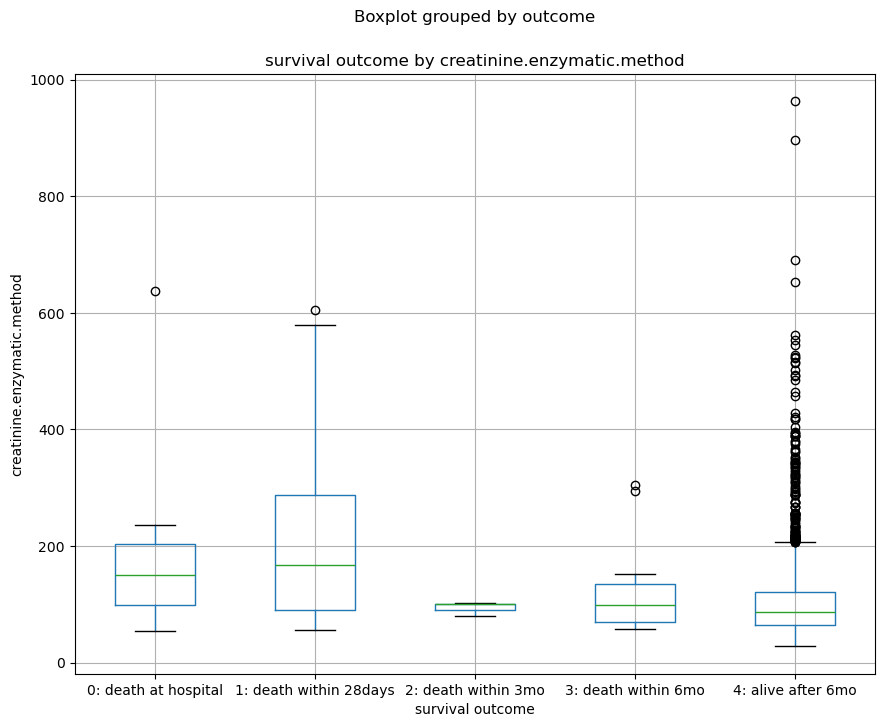

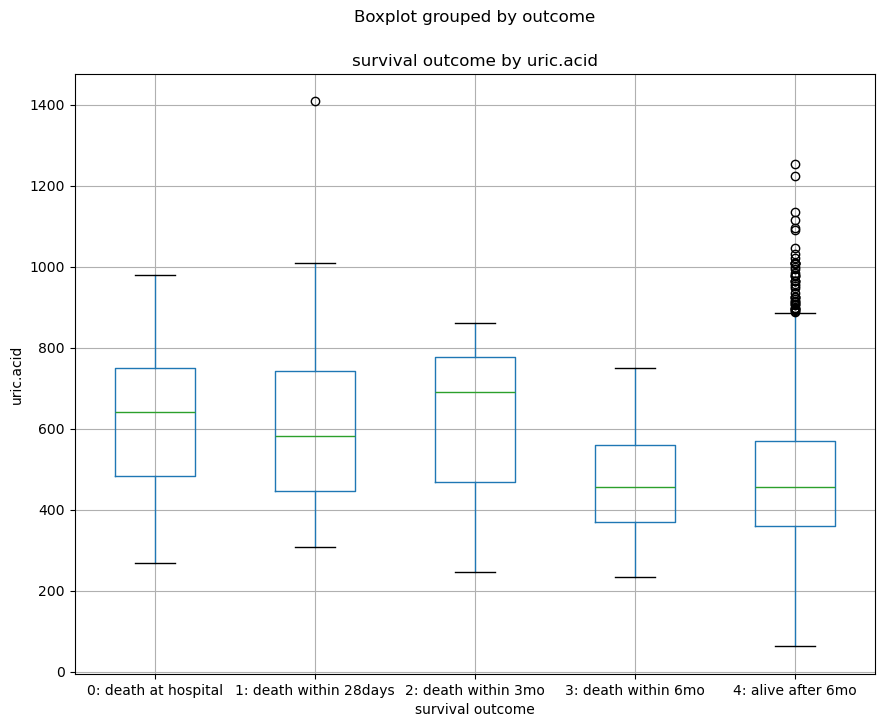

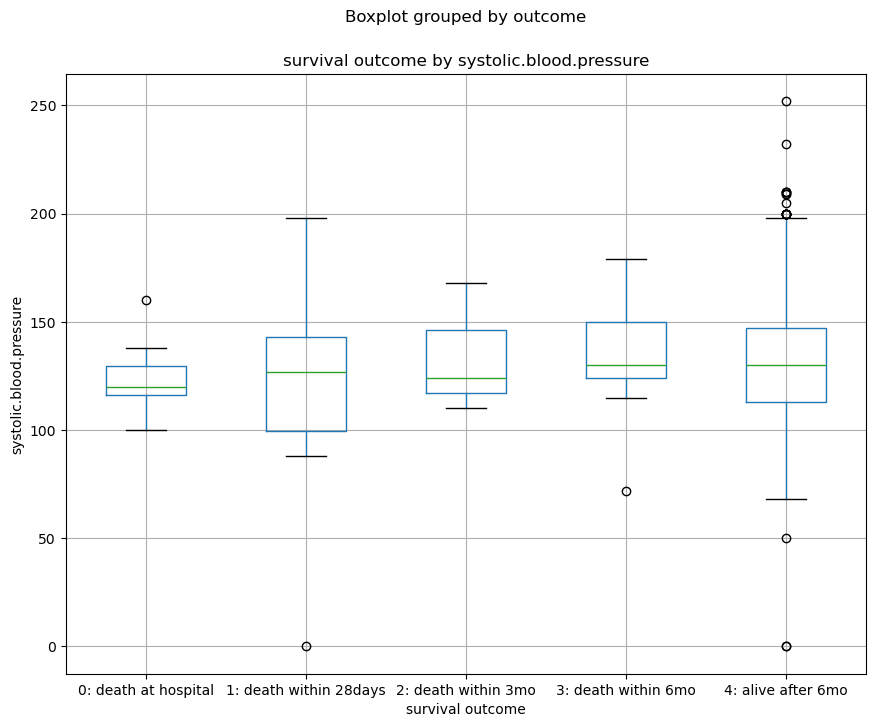

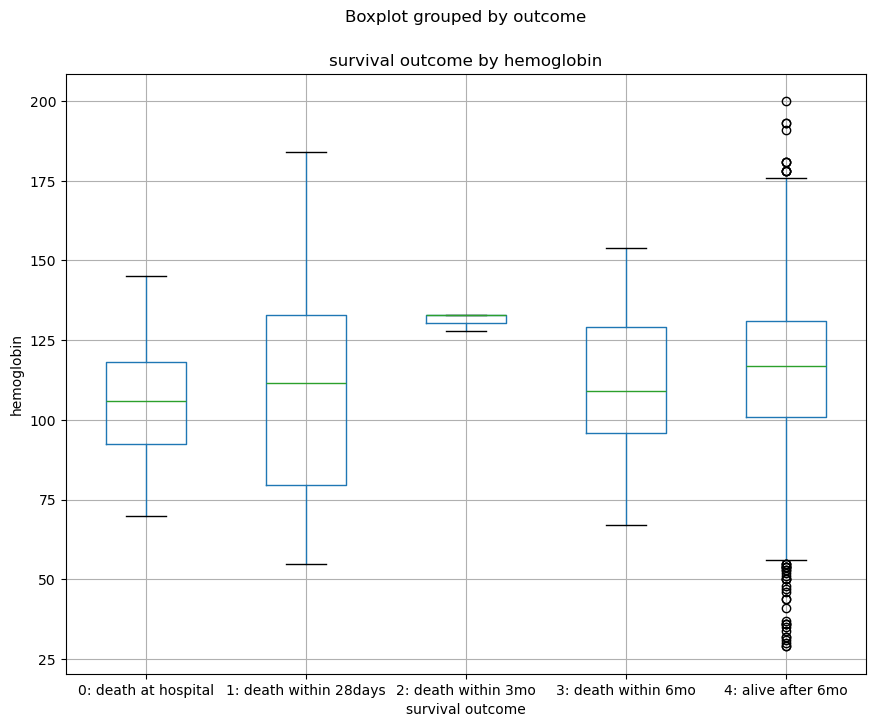

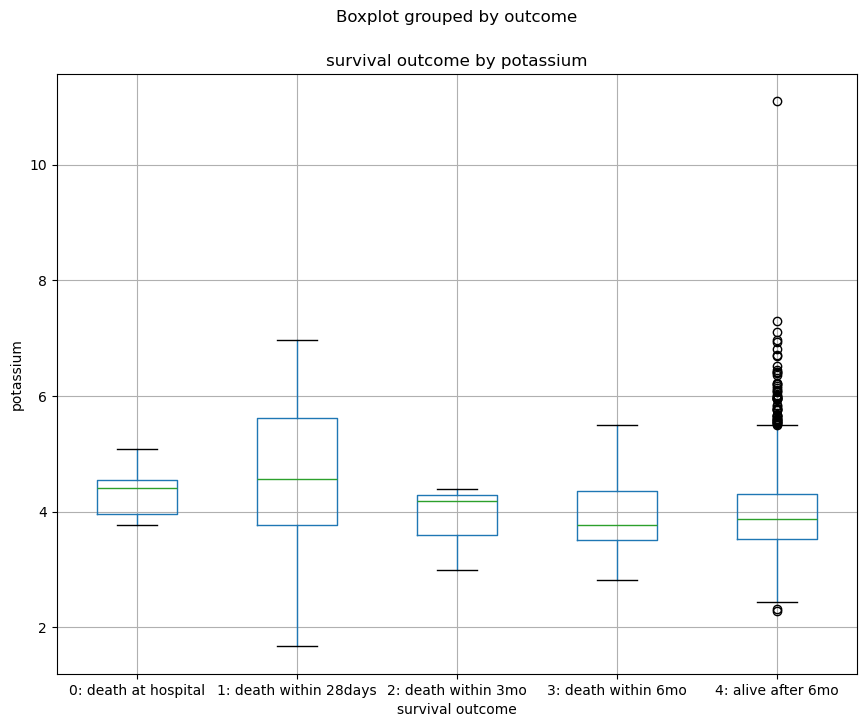

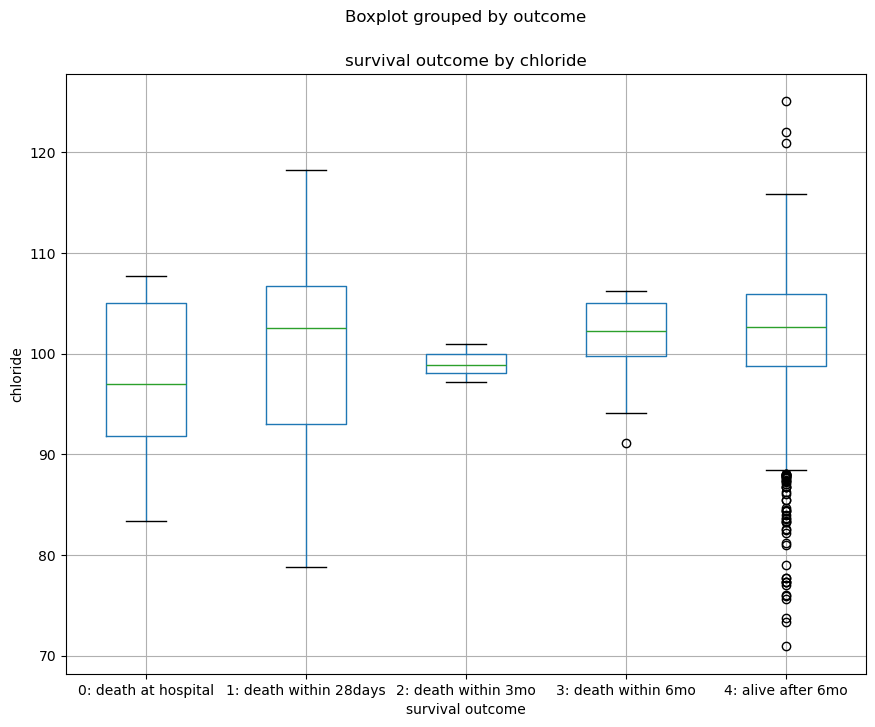

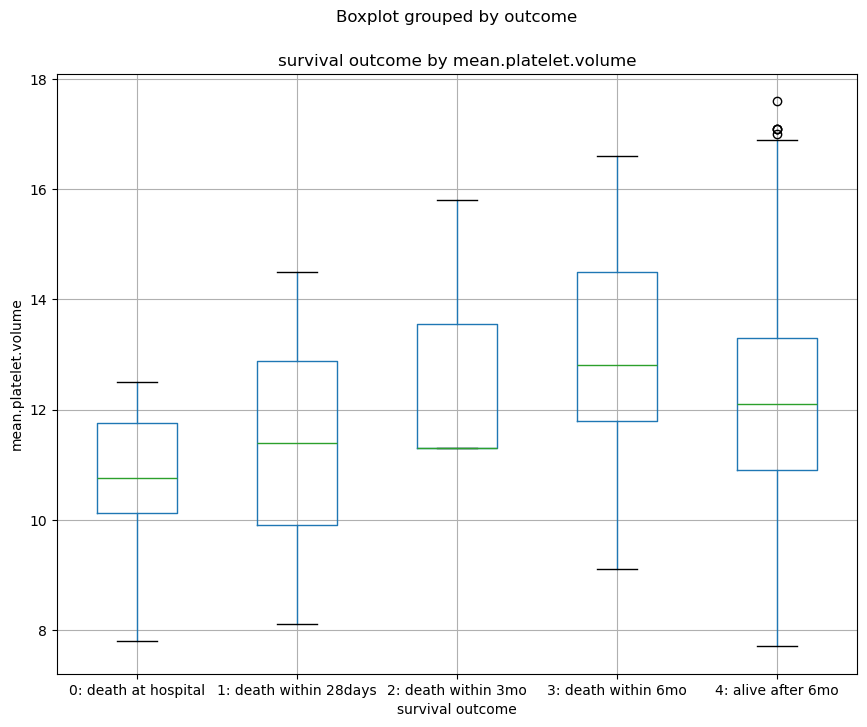

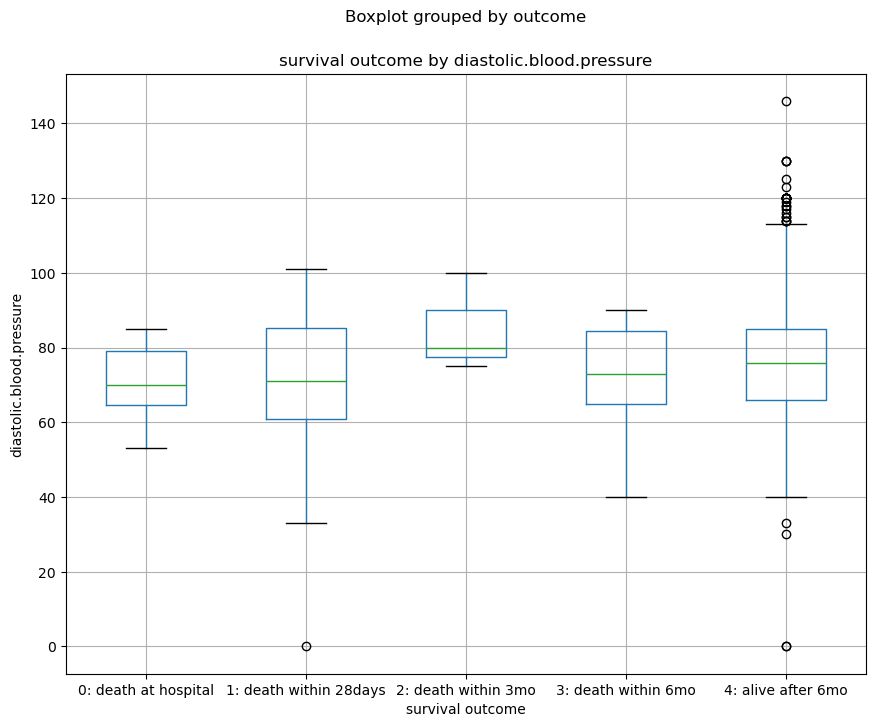

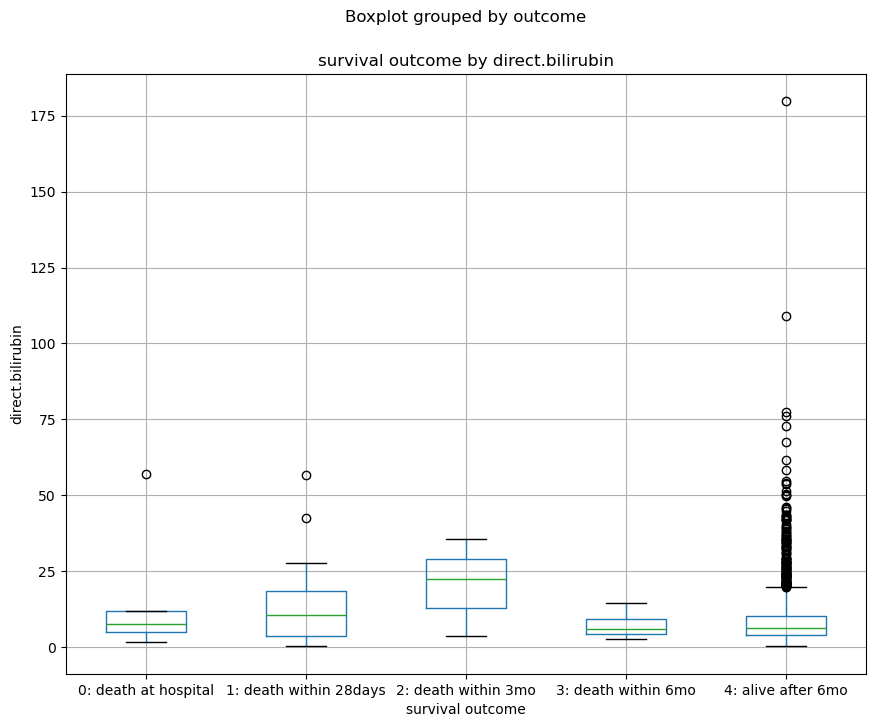

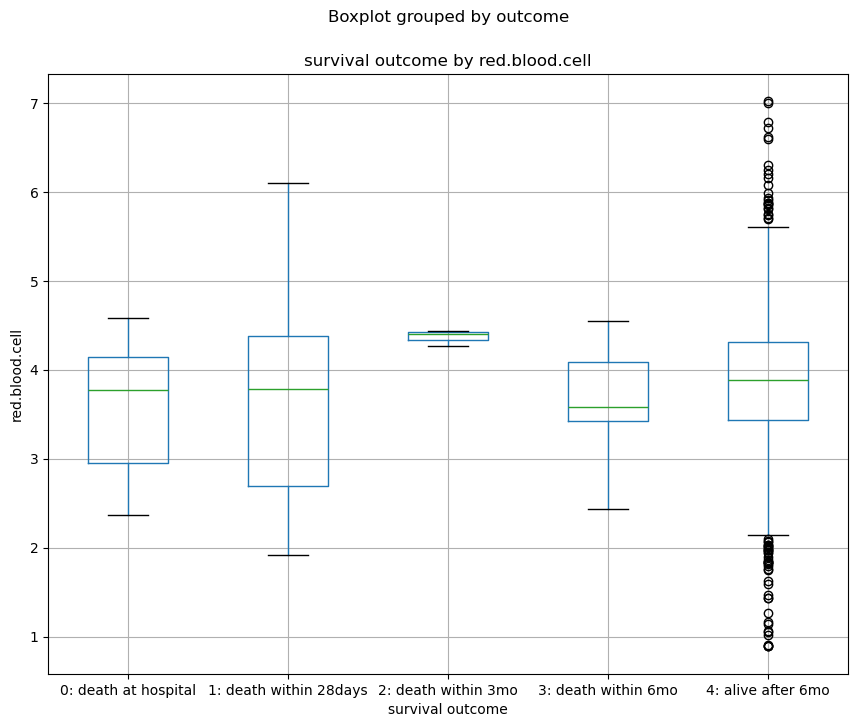

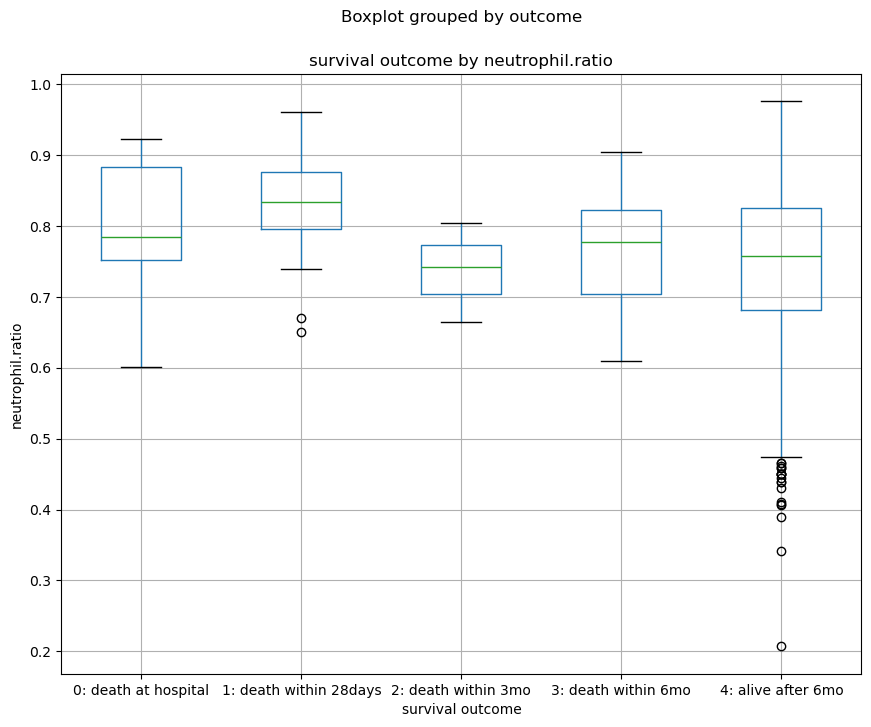

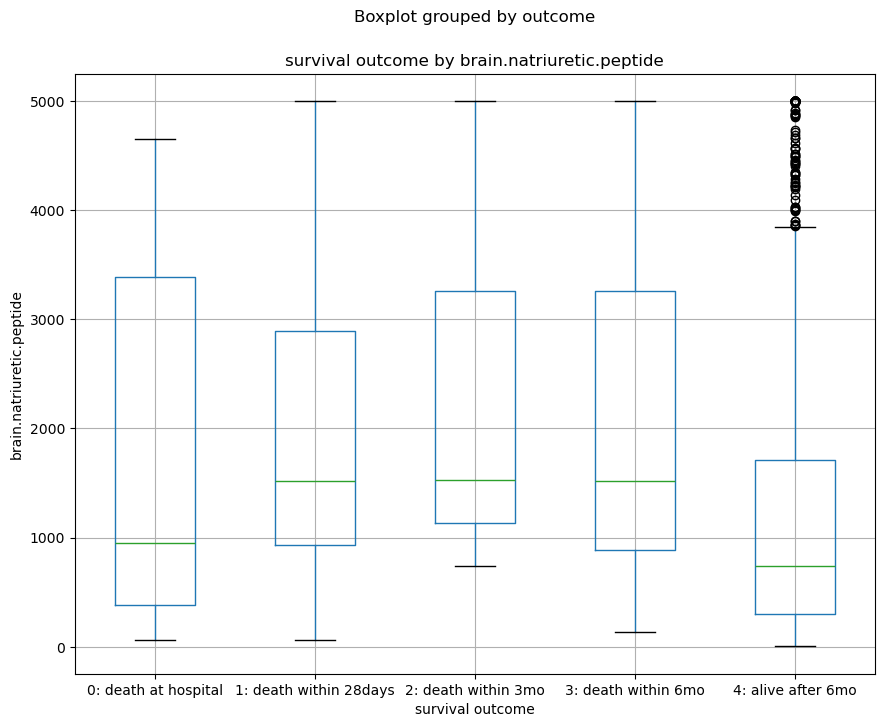

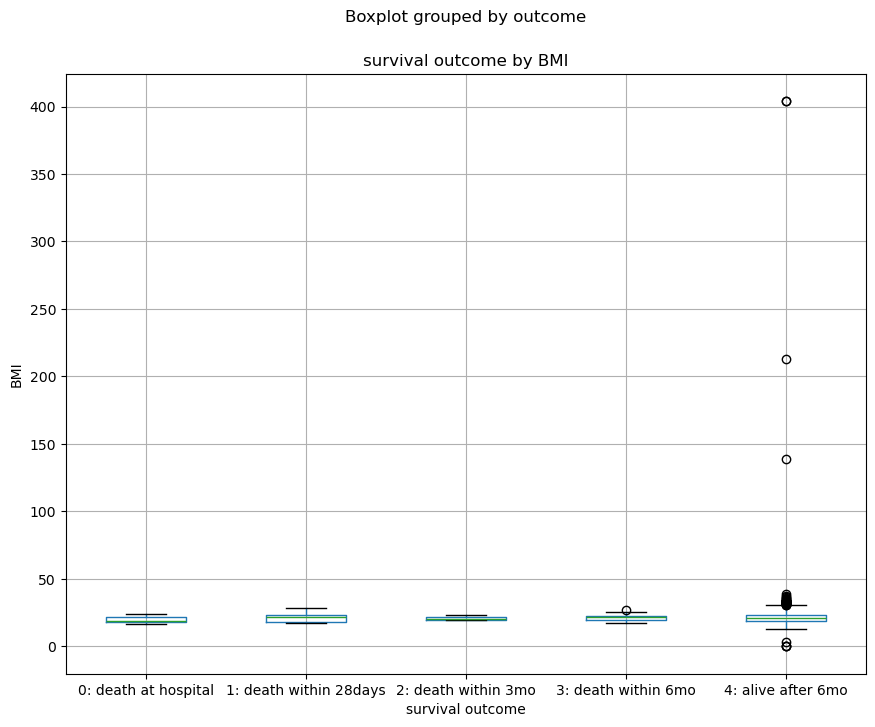

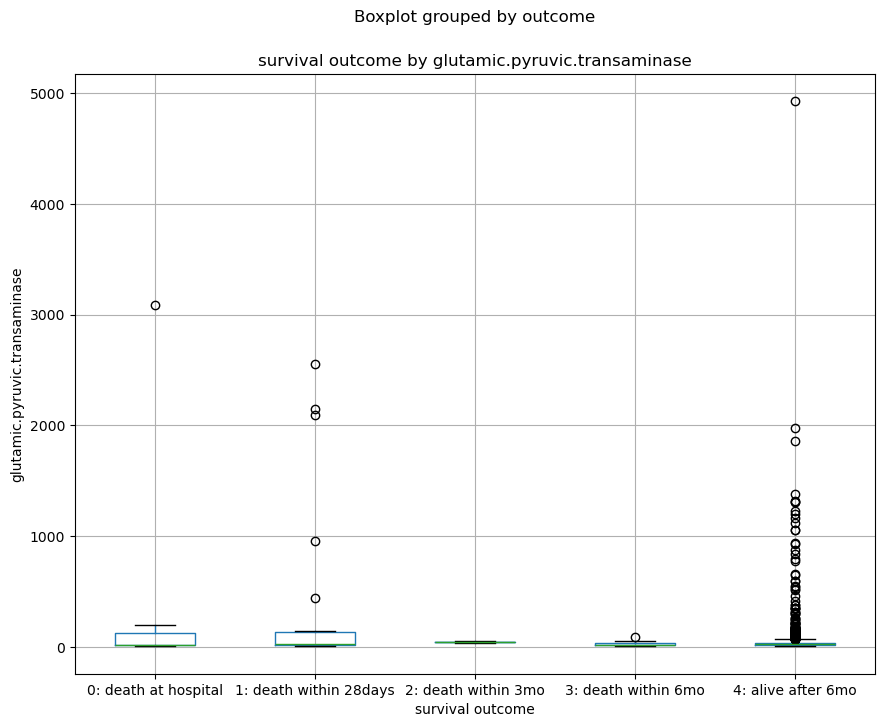

In [155]:
# EDA
# continuous x v. outcome:

# categorical x continuous = category-specific histograms, box plot, violin plot
for col in cont_cols:
    df[[col,'outcome']].boxplot(by='outcome', figsize=(10,8))
    plt.title(f'survival outcome by {col}')
    plt.xticks([1, 2, 3, 4, 5],
               ['0: death at hospital', '1: death within 28days', '2: death within 3mo', '3: death within 6mo', '4: alive after 6mo'])#, rotation=0)
    plt.xlabel('survival outcome')
    plt.ylabel(col)
    plt.show()

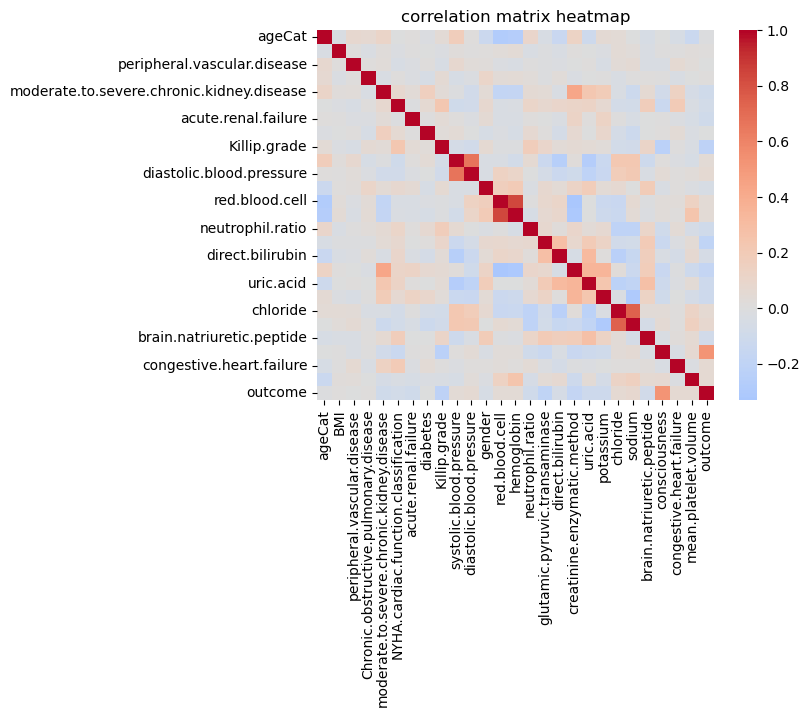

In [164]:
# EDA
# correlation matrix:
# corr_num_df = df_corr.copy() # df w/ transformed cols just for correlation
# print(set(df.columns).issubset(corr_num_df.columns)) # true
corr_num_df = df_corr[df.columns]
corr_matx = corr_num_df.corr()

# plt.figure(figsize=(10, 10))
plt.figure()

sns.heatmap(corr_matx, cmap='coolwarm', center=0)
plt.title('correlation matrix heatmap')
plt.show()

In [157]:
# EDA
# missing values
# how many missing values per column
missing_vals = df_og.isnull().sum()
missing_perc = (missing_vals / len(df_og)) * 100
# print(missing_vals)
# print(missing_perc)
# for col in df_og.columns:
#     miss = missing_vals[col]
#     perc = missing_perc[col]
#     if miss > 0:
#         print(f"{col}: {perc:.2f}%")

# cols with missing values 100-90, 80-90, 70-79, 60-69, 50-59, 40-49, 30-39, 20-29, 10-19, 1-9%
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9%', '10-19%', '20-29%', '30-39%', '40-49%', '50-59%', '60-69%', '70-79%', '80-89%', '90-100%']
df_missing = pd.DataFrame({'column': missing_vals.index, 'missing_count': missing_vals.values})
df_missing['missing_perc'] = (df_missing['missing_count'] / len(df_og)) * 100
df_missing['missing_bin'] = pd.cut(df_missing['missing_perc'], bins=bins, labels=labels, right=False)
missing_bin_counts = df_missing['missing_bin'].value_counts().sort_index()
print(missing_bin_counts)

# total missing values in dataset:
total_missing = missing_vals.sum()
total_values = df_og.size
overall_missing_perc = (total_missing / total_values) * 100
print(f"Total missing values: {total_missing}")
print(f"Total values in dataset: {total_values}")
print(f"Overall missing percentage: {overall_missing_perc:.2f}%")

# missing values in df:
missing_vals_df = df.isnull().sum()
missing_perc_df = (missing_vals_df / len(df)) * 100

for col in df.columns:
    miss = missing_vals_df[col]
    perc = missing_perc_df[col]
    if miss > 0:
        print(f"{col}: {miss}, {perc:.2f}%")

total_missing_df = missing_vals_df.sum()
total_values_df = df.size
overall_missing_perc_df = (total_missing_df / total_values_df) * 100
print(f"Total missing values: {total_missing_df}")
print(f"Total values in dataset: {total_values_df}")
print(f"Overall missing percentage: {overall_missing_perc_df:.2f}%")

missing_bin
0-9%       112
10-19%       7
20-29%       3
30-39%       1
40-49%       0
50-59%      27
60-69%       2
70-79%       4
80-89%       3
90-100%      7
Name: count, dtype: int64
Total missing values: 63753
Total values in dataset: 335336
Overall missing percentage: 19.01%
moderate.to.severe.chronic.kidney.disease: 2, 0.10%
red.blood.cell: 27, 1.34%
hemoglobin: 28, 1.39%
neutrophil.ratio: 27, 1.34%
glutamic.pyruvic.transaminase: 102, 5.08%
direct.bilirubin: 102, 5.08%
creatinine.enzymatic.method: 23, 1.15%
uric.acid: 23, 1.15%
potassium: 11, 0.55%
chloride: 11, 0.55%
sodium: 11, 0.55%
brain.natriuretic.peptide: 35, 1.74%
mean.platelet.volume: 103, 5.13%
Total missing values: 505
Total values in dataset: 54216
Overall missing percentage: 0.93%


In [158]:
# SPLITTING

# X & y
X = df.loc[:, df.columns != 'outcome']
y = df['outcome']

# use sklearn to split the dataset into 60% training, 20% validation, and 20% test sets
train_size = 0.6
val_size = 0.2
test_size = 0.2
random_state = 42  
# 1) split - train & other 
X_train, X_other, y_train, y_other = train_test_split(X,y, train_size = train_size, random_state = random_state)
# 2) split - val & test
split2_size = val_size / (val_size + test_size)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other, train_size = split2_size, random_state = random_state)

In [163]:
# PREPROCESSING

# cat_cols = ['NYHA.cardiac.function.classification', 'Killip.grade', 'consciousness', 'ageCat', 'gender',
#             'peripheral.vascular.disease', 'Chronic.obstructive.pulmonary.disease', 'moderate.to.severe.chronic.kidney.disease', 
#             'acute.renal.failure', 'diabetes', 'congestive.heart.failure', 'peripheral.vascular.disease']
# not_cont = cat_cols + ['outcome']
# cont_cols = list(set(df.columns) - set(not_cont))

cont_ftrs = cont_cols
cat_ftrs = ['gender', 'peripheral.vascular.disease', 'Chronic.obstructive.pulmonary.disease',
            'moderate.to.severe.chronic.kidney.disease', 'acute.renal.failure', 'congestive.heart.failure']
ord_ftrs = ['NYHA.cardiac.function.classification', 'Killip.grade', 'consciousness', 'ageCat']
ord_cats = [['II', 'III', 'IV'],
            ['I', 'II', 'III', 'IV'],
            ['Nonresponsive', 'ResponsiveToPain', 'ResponsiveToSound', 'Clear'],
            ['(21,29]', '(29,39]', '(39,49]', '(49,59]', '(59,69]', '(69,79]', '(79,89]', '(89,110]']]

# Standard Scaler: (continuous)
    # BMI, SBP, DBP, neutrophil ratio, glutamic pyruvic transaminase, direct bilirubin, Cr, uric acid, K, Cl, Na, brain natriuretic peptide, mean platelet vol
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train[cont_ftrs])
X_val_scaler = scaler.transform(X_val[cont_ftrs])
X_test_scaler = scaler.transform(X_test[cont_ftrs])

# OHE: (categorical)
    # gender, peripheral vascular disease, COPD, chronic kidney disease, acute renal failure, CHF
ohe = OneHotEncoder(sparse_output=False)#, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[cat_ftrs])
X_val_ohe = ohe.transform(X_val[cat_ftrs])
X_test_ohe = ohe.transform(X_test[cat_ftrs])

# Ordinal Encoder: (ordinal)
    # age range, NYHA cardiac function classification, Killip grade, consciousness
ord_enc = OrdinalEncoder(categories = ord_cats)
X_train_ord = ord_enc.fit_transform(X_train[ord_ftrs])
X_val_ord = ord_enc.transform(X_val[ord_ftrs])
X_test_ord = ord_enc.transform(X_test[ord_ftrs])

# combine preprocessed features using pd.concat:
# X_train_preproc = np.concatenate([X_train_scaler, X_train_ohe, X_train_ord], axis=1)
# X_val_preproc = np.concatenate([X_val_scaler, X_val_ohe, X_val_ord], axis=1)
# X_test_preproc = np.concatenate([X_test_scaler, X_test_ohe, X_test_ord], axis=1)